In [2]:
%matplotlib widget

import cdflib
import numpy as np
import datetime as dt
import spiceypy as spice
import matplotlib.pyplot as plt
from spacepy import pycdf
from matplotlib.colors import LinearSegmentedColormap

# Old version for pycdf
"""
def print_info(cdf_file):
    for var_name in cdf_file.keys():
        print(f"Variable: {var_name}")
        print(f"  Data Type: {cdf_file[var_name].type()}")
        print(f"  Dimensions: {cdf_file[var_name].shape}")
        print(f"  Attributes: {cdf_file[var_name].attrs}")
        print()
    return
"""

def print_info(cdf):

    for key, value in cdf.globalattsget().items():
        print(f"Global attribute: {key} = {value}")

    for variable in cdf.cdf_info().zVariables:
        print()
        print(f"Variable: {variable}")
        print(f"Shape: {cdf.varget(variable).shape}")
        print(f"Data type: {cdf.varinq(variable).Data_Type_Description}")
        for key, value in cdf.varattsget(variable).items():
            print(f"Variable attribute: {key} = {value}")

def filter_out_start_config_noise(data, epoch, removal_width = 32, new_config_delay = 0.1):
    # Create a mask for the data
    noise_mask = np.zeros(len(data))

    # Mask the next samples when dt is above new_config_delay, for which a new config. has been made
    delta_t = np.diff(epoch)
    delta_t = [dt.total_seconds() for dt in delta_t]

    i = 0
    for dt in delta_t:
        if dt > new_config_delay:
            noise_mask[i:i+removal_width] = 1
        i +=1

    noise_mask[:removal_width] = 1

    data[noise_mask == 1] = np.nan

    return data

def multiply_lists_by_33matrix(list1, list2, list3, matrix):
    res1 = np.zeros(len(list1))
    res2 = np.zeros(len(list1))
    res3 = np.zeros(len(list1))
    for i in range(len(list1)):
        vector = np.array([list1[i], list2[i], list3[i]])
        res1[i] = vector[0]*matrix[0, 0] + vector[1]*matrix[0, 1] + vector[2]*matrix[0, 2]
        res2[i] = vector[0]*matrix[1, 0] + vector[1]*matrix[1, 1] + vector[2]*matrix[1, 2]
        res3[i] = vector[0]*matrix[2, 0] + vector[1]*matrix[2, 1] + vector[2]*matrix[2, 2]
    return res1, res2, res3

def multiply_lists_by_44matrix(list1, list2, list3, list4, matrix):
    res1 = np.zeros(len(list1))
    res2 = np.zeros(len(list1))
    res3 = np.zeros(len(list1))
    res4 = np.zeros(len(list1))
    for i in range(len(list1)):
        vector = np.array([list1[i], list2[i], list3[i], list4[i]])
        res1[i] = vector[0]*matrix[0, 0] + vector[1]*matrix[0, 1] + vector[2]*matrix[0, 2] + vector[3]*matrix[0, 3]
        res2[i] = vector[0]*matrix[1, 0] + vector[1]*matrix[1, 1] + vector[2]*matrix[1, 2] + vector[3]*matrix[1, 3]
        res3[i] = vector[0]*matrix[2, 0] + vector[1]*matrix[2, 1] + vector[2]*matrix[2, 2] + vector[3]*matrix[2, 3]
        res4[i] = vector[0]*matrix[3, 0] + vector[1]*matrix[3, 1] + vector[2]*matrix[3, 2] + vector[3]*matrix[3, 3]
    return res1, res2, res3, res4

def plot_orbits(kernels, frame, start_date, end_date, center_body, bodies, colors, sun_direction=False):
    """
    Plot the orbits of specified celestial bodies over a given time range.

    Parameters:
    - kernels: List of SPICE kernel files to load.
    - start_date: Start date for the time range (YYYY-MM-DD).
    - end_date: End date for the time range (YYYY-MM-DD).
    - center_body: The body around which the other bodies are plotted.
    - bodies: List of bodies to plot.
    - colors: List of colors for each body.
    """
    radius = center_bodies[center_body]["radius"]
    center_color = center_bodies[center_body]["color"]
    scale = center_bodies[center_body]["scale"]

    # Load SPICE kernels
    for kernel in kernels:
        spice.furnsh(kernel)

    # Convert dates to ephemeris time
    start_epoch = spice.str2et(start_date)
    end_epoch = spice.str2et(end_date)

    # Generate time array
    times = np.linspace(start_epoch, end_epoch, 1000)

    # Create a 3D plot
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the center body (e.g., Sun, Earth, Saturn) as a wireframe
    u = np.linspace(0, 2 * np.pi, 10)
    v = np.linspace(0, np.pi, 10)
    x = radius * np.outer(np.cos(u), np.sin(v))
    y = radius * np.outer(np.sin(u), np.sin(v))
    z = radius * np.outer(np.ones(np.size(u)), np.cos(v))

    if sun_direction:
        sun_pos, _ = spice.spkpos("SUN", times[-1], frame, "NONE", center_body)
        sun_pos = sun_pos / np.linalg.norm(sun_pos)

        dot_products = np.zeros_like(x)
        for i in range(x.shape[0]):
            for j in range(x.shape[1]):
                dot_products[i, j] = np.dot(sun_pos, np.array([x[i, j], y[i, j], z[i, j]]))

        # Normalize dot products to range [0, 1] for colormap
        normalized_dot = (dot_products + 1) / 2

        # Create a custom colormap from center_color to black
        custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", ["black", center_color], N=2)

        # Normalize dot products to range [0, 1] for colormap
        normalized_dot = (dot_products + 1) / 2

        # Apply the custom colormap
        colmap = custom_cmap(normalized_dot)

        # Plot the surface with the colormap
        surf = ax.plot_surface(x, y, z, facecolors=colmap, rstride=1, cstride=1)
        surf.set_facecolor((0, 0, 0, 0))  # Set face color to transparent
    else:
        # Plot the wireframe without Sun direction consideration
        ax.plot_wireframe(x, y, z, color=center_color)

    # Plot the orbits
    for body, color in zip(bodies, colors):
        pos_body, _ = spice.spkpos(body, times, frame, "NONE", center_body)
        ax.plot(pos_body[:, 0], pos_body[:, 1], pos_body[:, 2], color=color)
        ax.scatter(pos_body[-1, 0], pos_body[-1, 1], pos_body[-1, 2], color=color, label=body)

    # Set limits and labels
    ax.set_xlim(-scale, scale)
    ax.set_ylim(-scale, scale)
    ax.set_zlim(-scale, scale)
    ax.legend()

    plt.show()

    for kernel in kernels:
        spice.unload(kernel)

center_bodies = {
    "SUN": {"radius": 695700, "color": "yellow", "scale": 4e8},
    "EARTH": {"radius": 6371, "color": "blue", "scale": 4e6},
    "SATURN": {"radius": 58232, "color": "yellow", "scale": 4e6},
    "MERCURY": {"radius": 2439.7, "color": "gray", "scale": 4e4},
    "GANYMEDE": {"radius": 2634.1, "color": "lightgray", "scale": 4e4},
}

# J2000 reference date in UTC
REF_DATE = dt.datetime(2000, 1, 1, 11, 58, 55, 816)

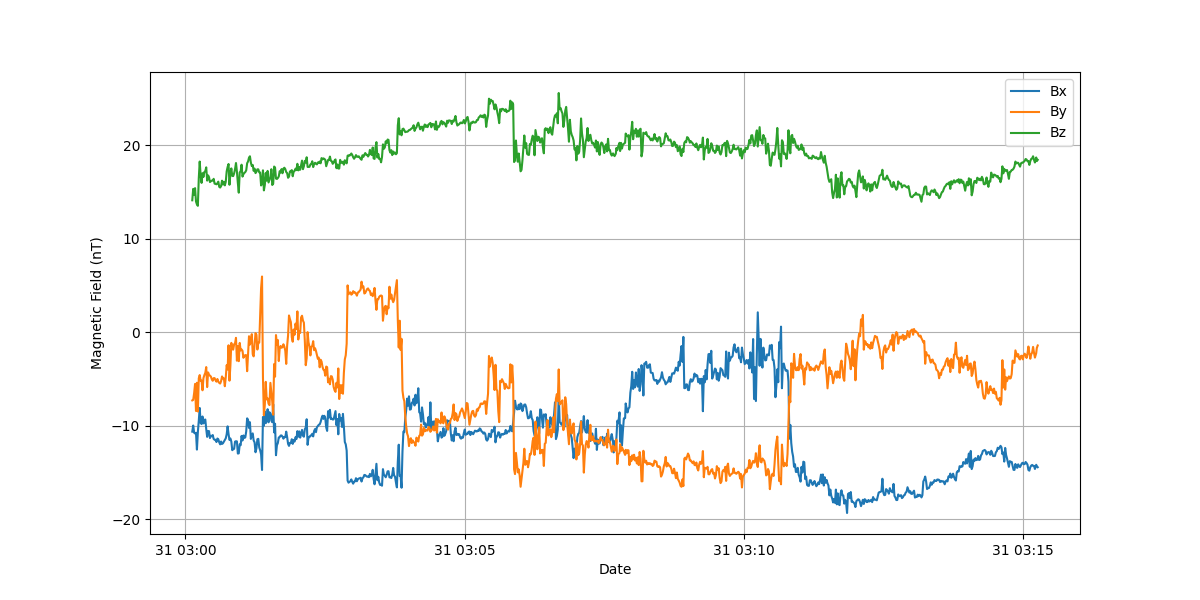

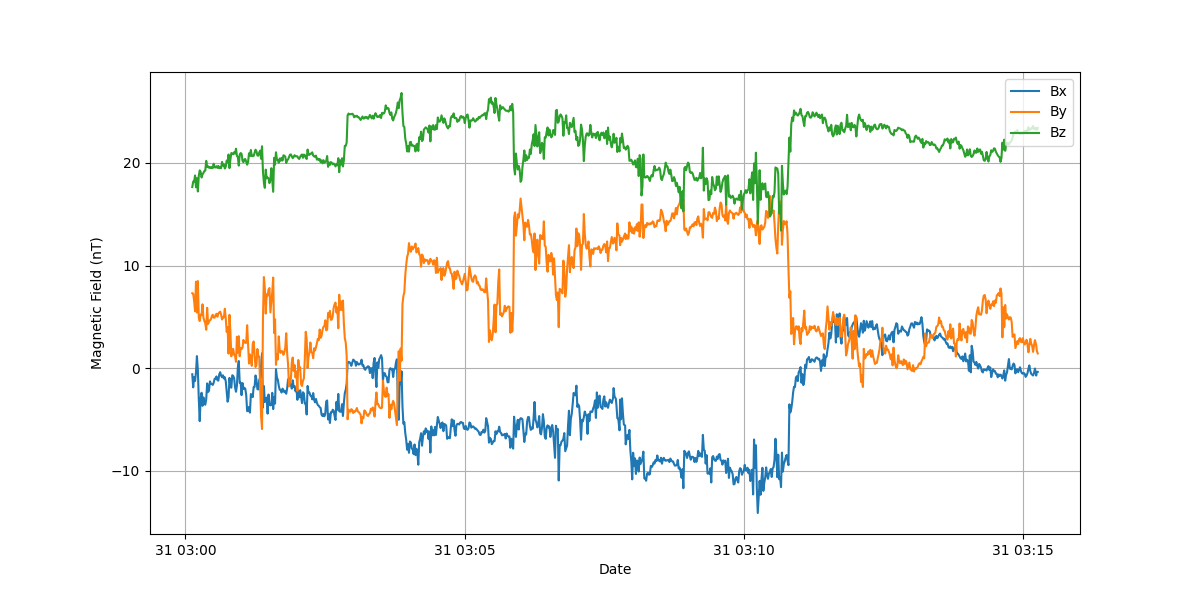

In [18]:
# Get and rotate JMAG data

"""
jmag_cdf = pycdf.CDF('../DATA/jmag_echoed/2025/03/31/JUICE_LU_RPWI-PPTD-LWYRPW79710_20250331T030003_V01.cdf')
Bx = jmag_cdf['LWT79713'][...]
By = jmag_cdf['LWT79714'][...]
Bz = jmag_cdf['LWT79715'][...]
jmag_epoch = jmag_cdf['Epoch'][...]
"""

jmag_cdf = cdflib.CDF('../DATA/jmag_echoed/2025/03/31/JUICE_LU_RPWI-PPTD-LWYRPW79710_20250331T030003_V01.cdf')

jmag_epoch = jmag_cdf.varget('Epoch')
Bx = jmag_cdf.varget('LWT79713')
By = jmag_cdf.varget('LWT79714')
Bz = jmag_cdf.varget('LWT79715')

jmag_epoch = [REF_DATE + dt.timedelta(seconds=epoch/1e9) for epoch in jmag_epoch]

plt.figure(figsize=(12, 6))
plt.plot(jmag_epoch, Bx, label='Bx')
plt.plot(jmag_epoch, By, label='By')
plt.plot(jmag_epoch, Bz, label='Bz')
plt.legend(loc = 'upper right')
plt.xlabel('Date')
plt.ylabel('Magnetic Field (nT)')
plt.grid()
plt.show()

# Rotation matrix to go from JMAG frame to JUICE frame
R = np.array([
    [-7.77145961*1e-1,  8.39299198*1e-17,   -6.29320391*1e-1],
    [-9.51729314*1e-17, -1.00000000*1e0,    -1.58371803*1e-17],
    [-6.29320391*1e-1,  4.75864657*1e-17,   7.77145961*1e-1]])

# Rotate the magnetic field vectors to the JUICE frame
Bx_rot = R[0,0]*Bx + R[0,1]*By + R[0,2]*Bz
By_rot = R[1,0]*Bx + R[1,1]*By + R[1,2]*Bz
Bz_rot = R[2,0]*Bx + R[2,1]*By + R[2,2]*Bz
Bx = Bx_rot
By = By_rot
Bz = Bz_rot

plt.figure(figsize=(12, 6))
plt.plot(jmag_epoch, Bx, label='Bx')
plt.plot(jmag_epoch, By, label='By')
plt.plot(jmag_epoch, Bz, label='Bz')
plt.legend(loc = 'upper right')
plt.xlabel('Date')
plt.ylabel('Magnetic Field (nT)')
plt.grid()
plt.show()

#pycdf.CDF.close(jmag_cdf)

Delta time: 5.266309296413032 hours


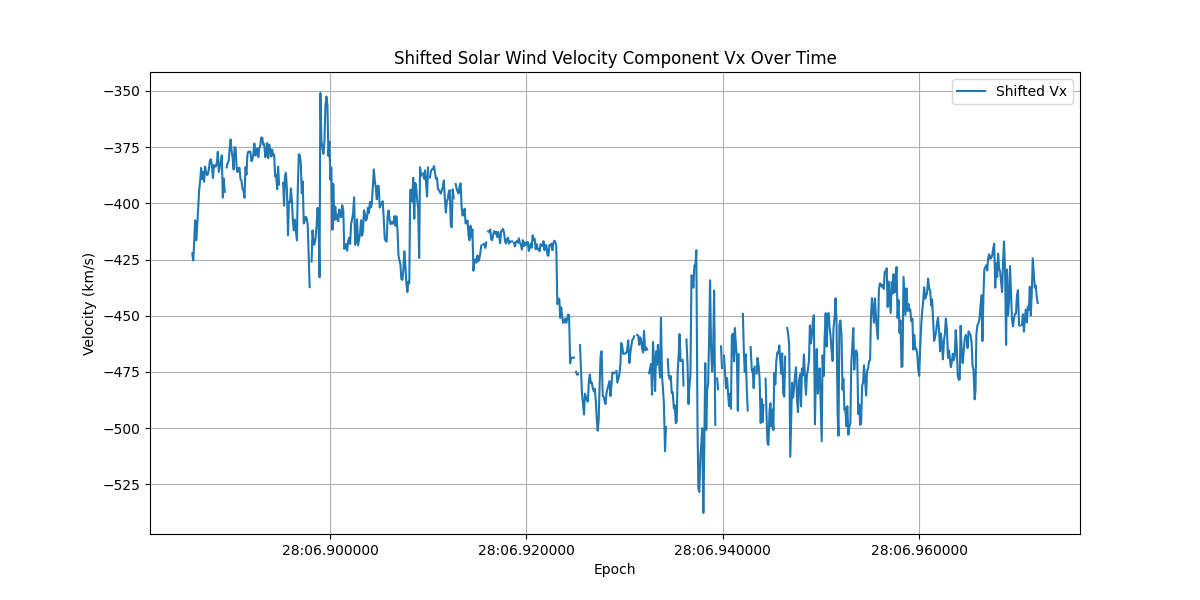

In [19]:
# Get and shift SW data

"""
sw_cdf = pycdf.CDF("../DATA\wi_k0s_swe_20250331000326_20250331235905_cdaweb.cdf")

# Extracting solar wind velocity components and spacecraft position components
V_GSE = sw_cdf['V_GSE'][...]
WIND_pos_gse = sw_cdf['SC_pos_gse'][...]
Epoch = sw_cdf['Epoch'][...]
"""

sw_cdf = cdflib.CDF("../DATA/wi_k0s_swe_20250331000326_20250331235905_cdaweb.cdf")
V_GSE = sw_cdf.varget('V_GSE')
WIND_pos_gse = sw_cdf.varget('SC_pos_gse')
Epoch = sw_cdf.varget('Epoch')
Epoch = np.array([REF_DATE + dt.timedelta(seconds=epoch/1e9) for epoch in Epoch])

V_GSE[V_GSE < -1e5] = np.nan

# Load the necessary SPICE kernels
spice.furnsh("../SPICE/JUICE/kernels/mk/juice_ops.tm")

# Specify time (UTC)
et = spice.str2et("2025-03-31T00:00:00")

# Get Earth's position relative to the Sun in J2000 frame
pos_earth_j2000, _ = spice.spkpos("EARTH", et, "J2000", "NONE", "SUN")

distance_earth_sun = np.linalg.norm(pos_earth_j2000)

WIND_pos_sun_centered_x = WIND_pos_gse[:, 0] - distance_earth_sun

WIND_distance_sun = np.sqrt(WIND_pos_sun_centered_x**2 + WIND_pos_gse[:, 1]**2 + WIND_pos_gse[:, 2]**2)

# Calculate the average of SC_distance_sun
avrg_WIND_distance_sun = np.nanmean(WIND_distance_sun)

pos_juice_j2000, _ = spice.spkpos("JUICE", et, "J2000", "NONE", "SUN")
distance_juice_sun = np.linalg.norm(pos_juice_j2000)

delta_distance = avrg_WIND_distance_sun - distance_juice_sun
sw_speed = -np.nanmean(V_GSE[:, 0], axis=0)
delta_time = delta_distance / sw_speed
print(f"Delta time: {delta_time/(60*60)} hours")

# Shift the solar wind data to delta_time seconds earlier
SW_epoch = Epoch - dt.timedelta(seconds=delta_time)
plt.figure(figsize=(12, 6))
plt.plot(SW_epoch, V_GSE[:, 0], label='Shifted Vx')
plt.title('Shifted Solar Wind Velocity Component Vx Over Time')
plt.xlabel('Epoch')
plt.ylabel('Velocity (km/s)')
plt.legend()
plt.grid()
plt.show()

spice.unload("SPICE/JUICE/kernels/mk/juice_ops.tm")
#pycdf.CDF.close(sw_cdf)

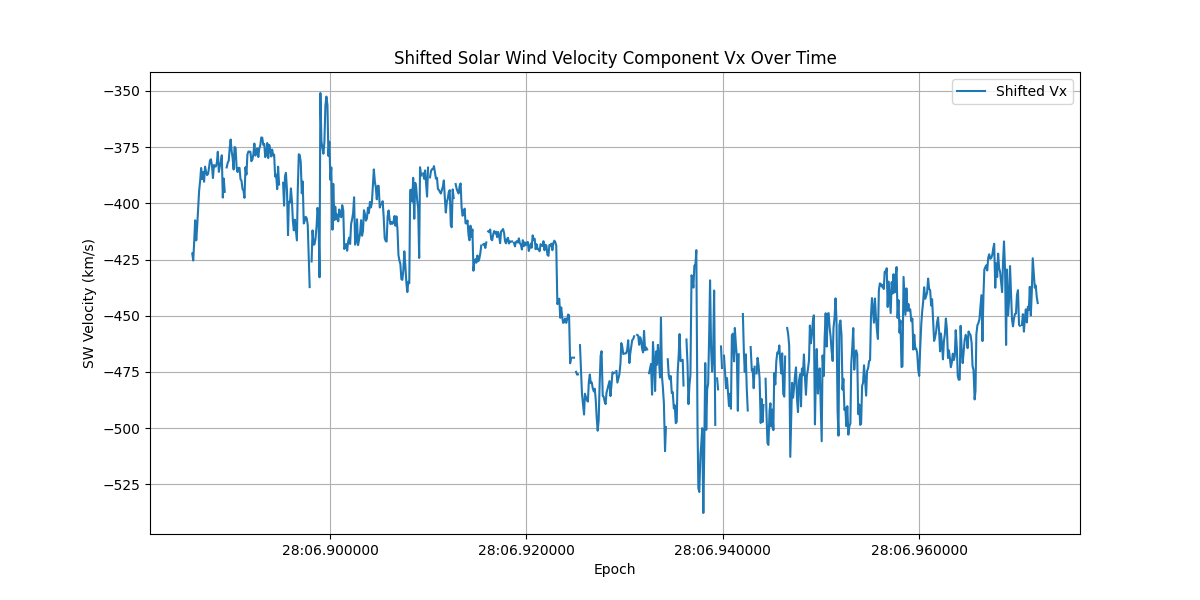

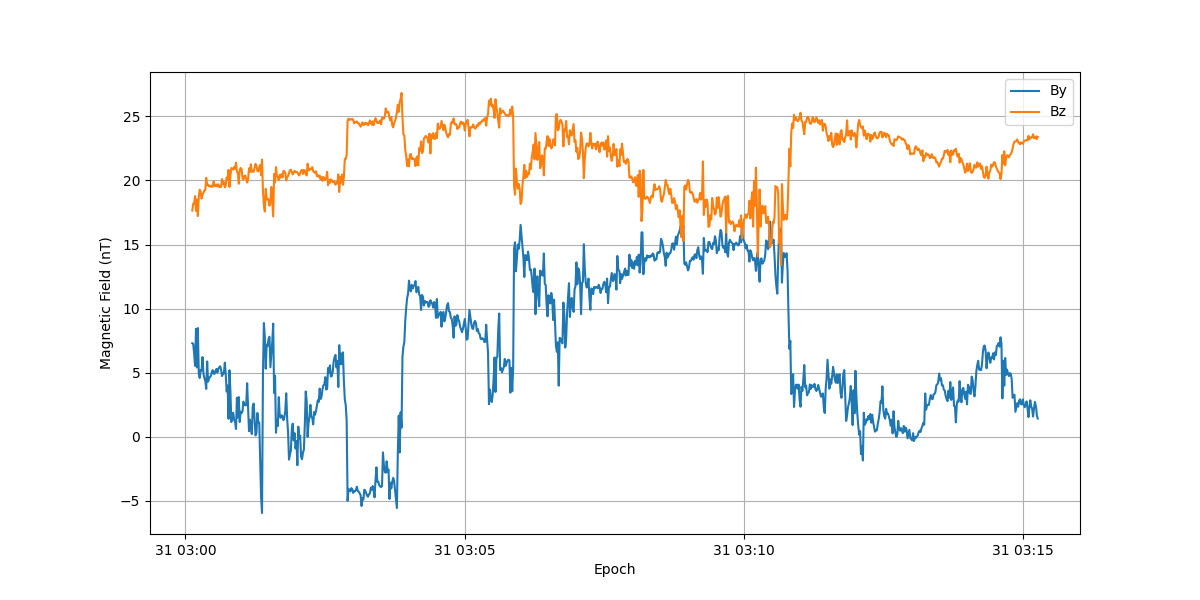

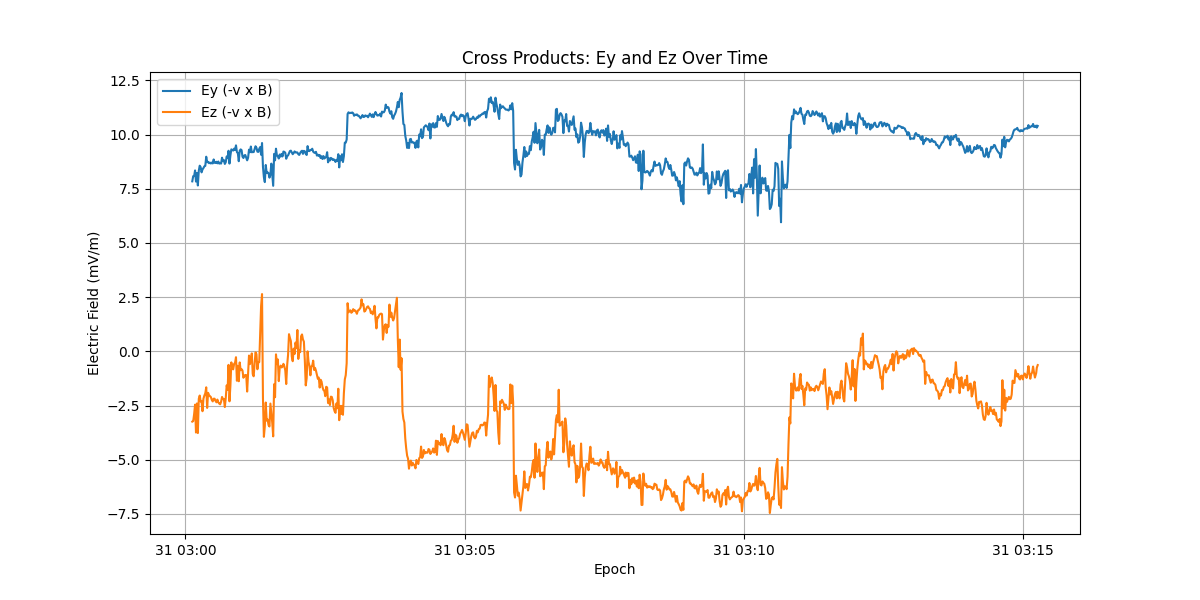

In [21]:
# Calculate v cross B

# X axis for JUICE points away from HGA antenna, so AWAY from the Sun, so SW speed needs to be positive

# Ensure SW_epoch and V_GSE are available
cross_products = np.zeros((len(jmag_epoch), 3))

for i in range(len(jmag_epoch)):
    # Calculate the absolute time difference
    time_diffs = np.abs(SW_epoch - jmag_epoch[i])
    # Sort the indices of time differences in ascending order
    sorted_indices = np.argsort(time_diffs)
    
    # Find the first non-nan Vx value
    sw_vx = np.nan
    for idx in sorted_indices:
        if not np.isnan(V_GSE[idx, 0]):
            sw_vx = V_GSE[idx, 0]
            break
    sw_vx = -sw_vx  # In JUICE frame, the velocity is negative
    
    cross_products[i] = [0, -float(-Bz[i] * sw_vx * 1e-6), -float(By[i] * sw_vx * 1e-6)]

EyvCB = cross_products[:, 1]
EzvCB = cross_products[:, 2]

plt.figure(figsize=(12, 6))
plt.plot(SW_epoch, V_GSE[:, 0], label='Shifted Vx')
plt.title('Shifted Solar Wind Velocity Component Vx Over Time')
plt.xlabel('Epoch')
plt.ylabel('SW Velocity (km/s)')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(jmag_epoch, By, label='By')
plt.plot(jmag_epoch, Bz, label='Bz')
plt.xlabel('Epoch')
plt.ylabel('Magnetic Field (nT)')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(jmag_epoch, cross_products[:, 1]*1e3, label='Ey (-v x B)')
plt.plot(jmag_epoch, cross_products[:, 2]*1e3, label='Ez (-v x B)')
plt.title('Cross Products: Ey and Ez Over Time')
plt.xlabel('Epoch')
plt.ylabel('Electric Field (mV/m)')
plt.legend()
plt.grid()
plt.show()

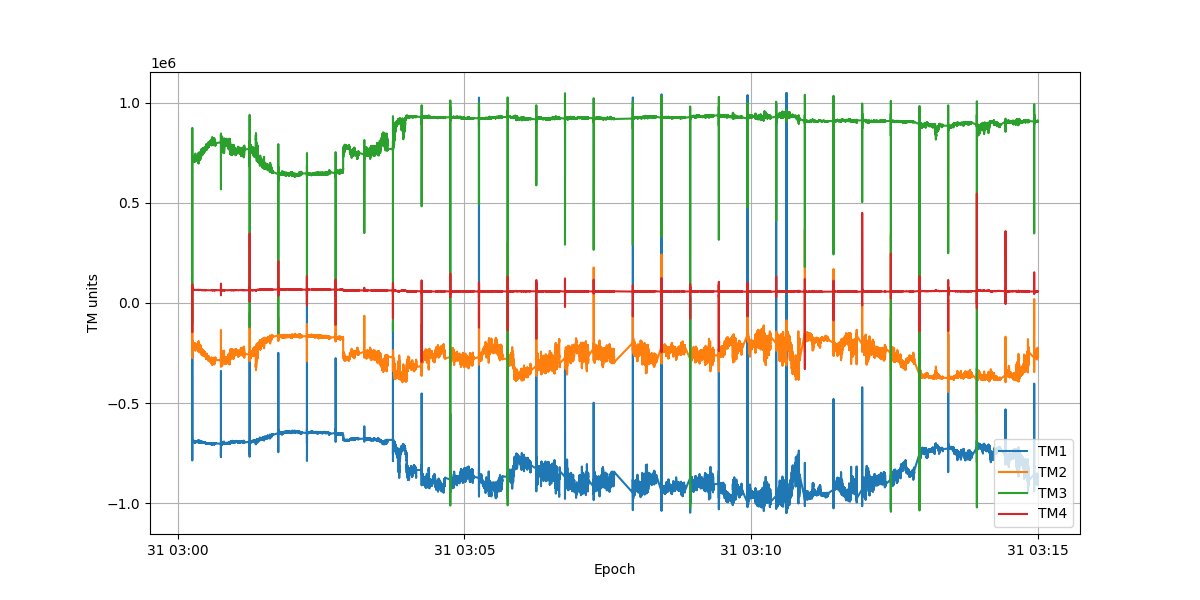

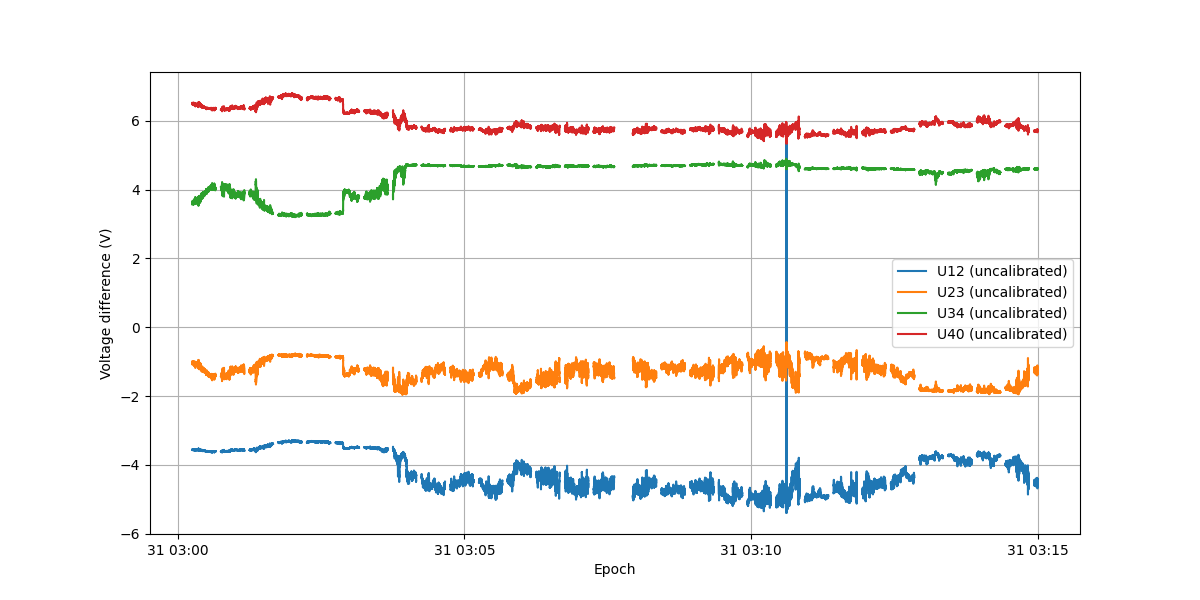

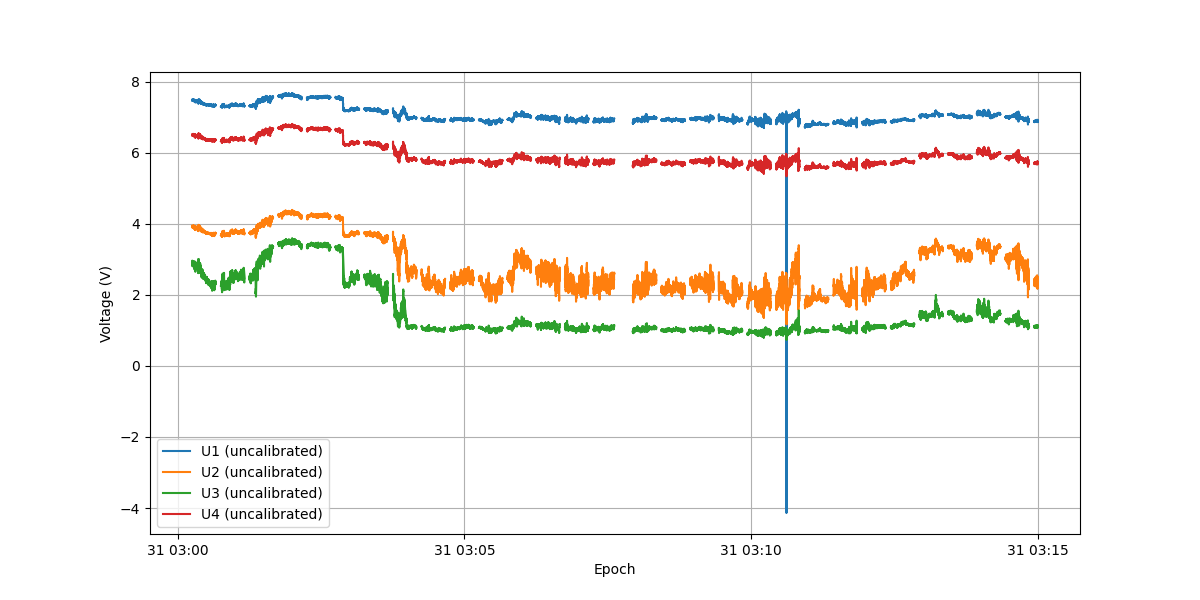

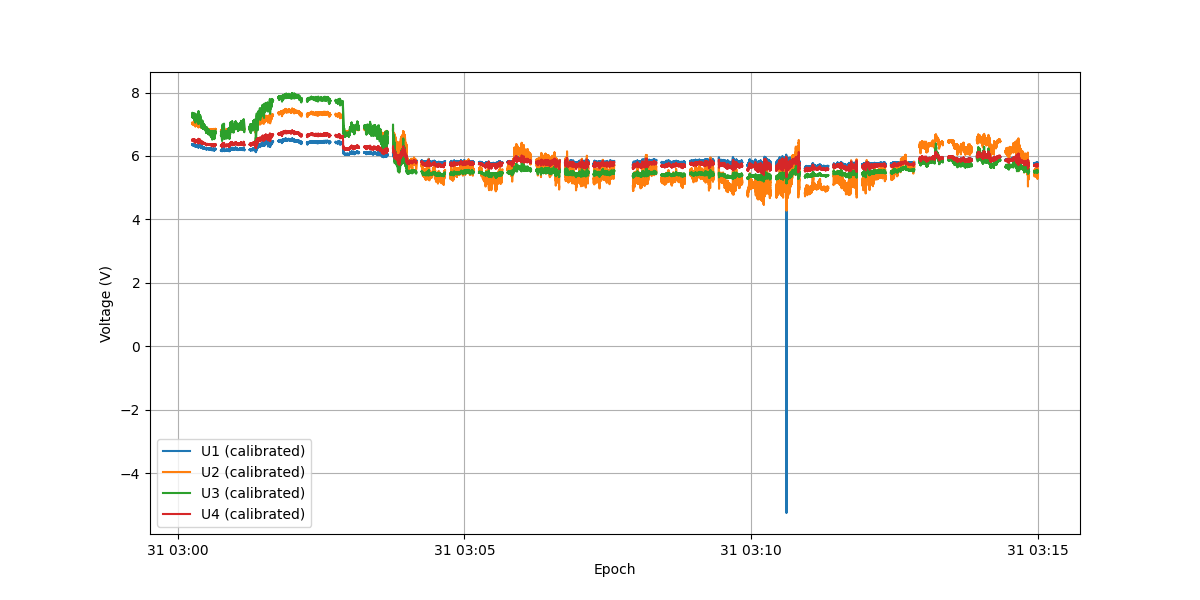

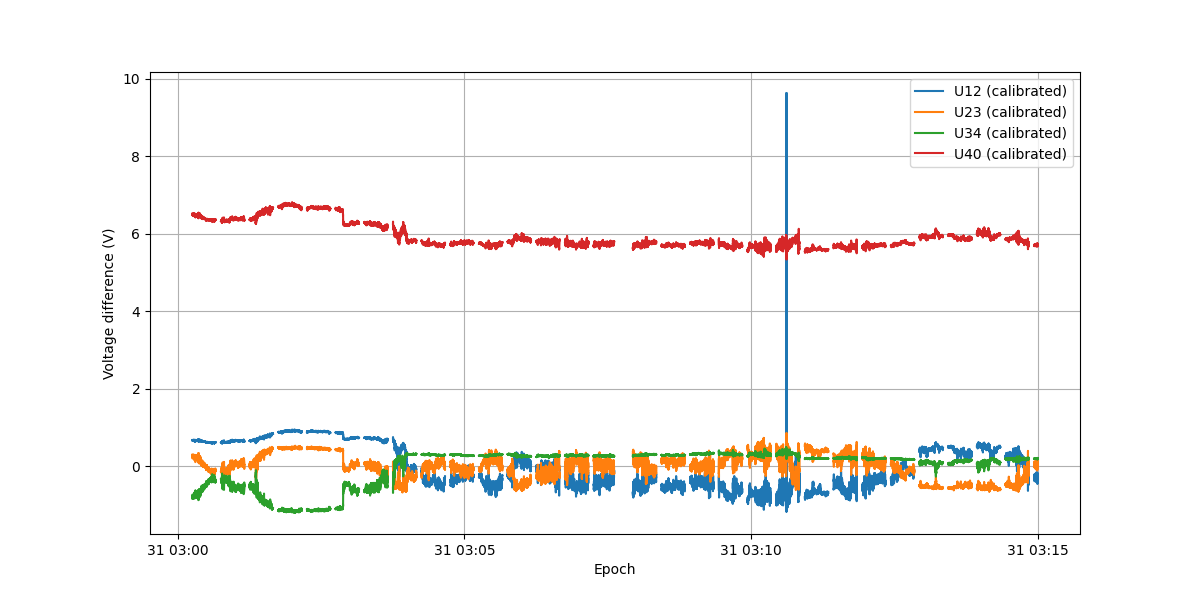

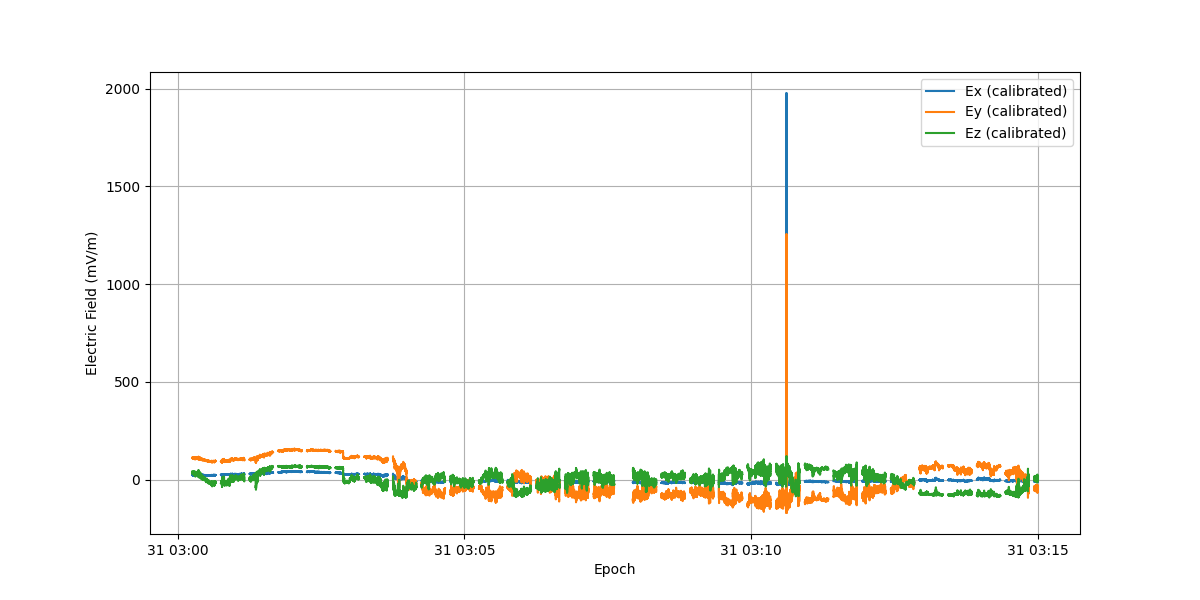

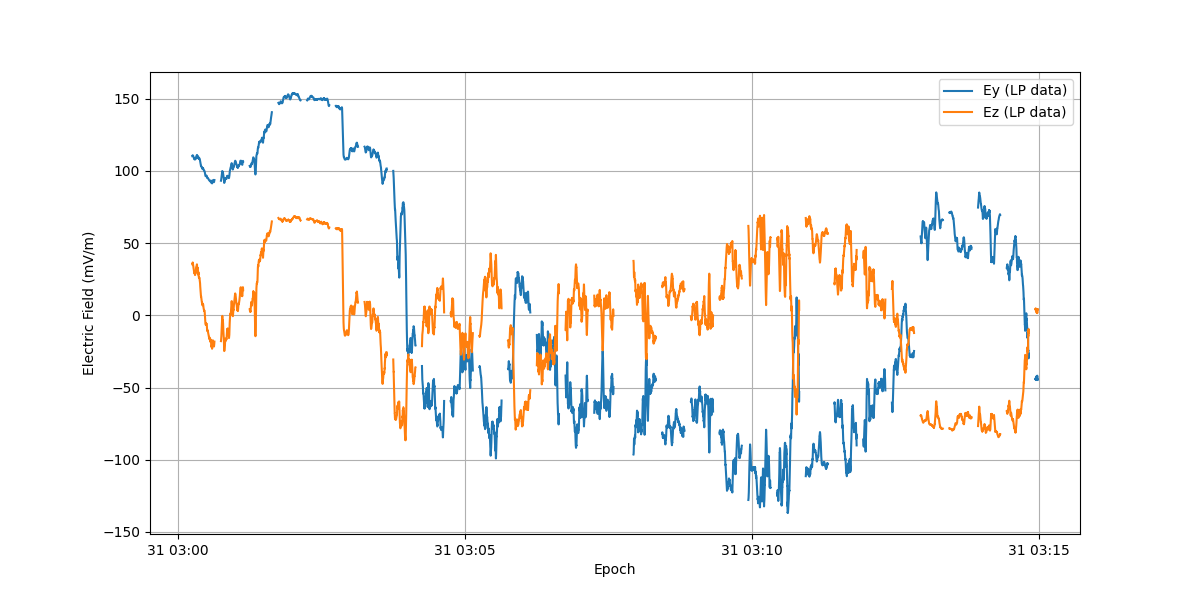

In [22]:
# Getting E field from raw LP data * coefficient

nb_final_removed = 11000

"""
LP_cdf = pycdf.CDF('../DATA/JUICE_L1a_RPWI-LP-SID1_RICH_DE763_SNAP_20250331T030011_V02.cdf')

lp_epoch = LP_cdf['Epoch'][...][:-nb_final_removed]

TM1 = LP_cdf['LP_DATA'][:, 0][:-nb_final_removed]
TM2 = LP_cdf['LP_DATA'][:, 1][:-nb_final_removed]
TM3 = LP_cdf['LP_DATA'][:, 2][:-nb_final_removed]
TM4 = LP_cdf['LP_DATA'][:, 3][:-nb_final_removed]
"""

LP_cdf = cdflib.CDF('../DATA/JUICE_L1a_RPWI-LP-SID1_RICH_DE763_SNAP_20250331T030011_V02.cdf')

lp_epoch = LP_cdf.varget('Epoch')[:-nb_final_removed]
TM1 = LP_cdf.varget('LP_DATA')[:, 0][:-nb_final_removed]
TM2 = LP_cdf.varget('LP_DATA')[:, 1][:-nb_final_removed]
TM3 = LP_cdf.varget('LP_DATA')[:, 2][:-nb_final_removed]
TM4 = LP_cdf.varget('LP_DATA')[:, 3][:-nb_final_removed]
lp_epoch = np.array([REF_DATE + dt.timedelta(seconds=epoch/1e9) for epoch in lp_epoch])

delta2volt = np.array([
    [-1.0, -1.0, -1.0, 1.0],
    [0.0, -1.0, -1.0, 1.0],
    [0.0, 0.0, -1.0, 1.0],
    [0.0, 0.0, 0.0, 1.0]])

volt2delta = np.array([
    [-1.0, 1.0, 0.0, 0.0],
    [0.0, -1.0, 1.0, 0.0],
    [0.0, 0.0, -1.0, 1.0],
    [0.0, 0.0, 0.0, 1.0]])

volt2E = np.array([
    [0.1852, 0.1923, 0.1917],
    [0.1320, -0.0112, -0.0322],
    [0.0, 0.1398, 0.0]])

TM2delta = np.array([[5.15*1e-6], [4.97*1e-6], [5.07*1e-6], [9.94*1e-5]])

# Define the start and end dates for filtering
start_date = dt.datetime(2025, 3, 31, 3, 0, 0)
end_date = dt.datetime(2025, 3, 31, 3, 15, 0)

# Filter the TM lists and epoch list
filtered_indices = [i for i, t in enumerate(lp_epoch) if start_date <= t <= end_date]
lp_epoch = lp_epoch[filtered_indices]
TM1 = TM1[filtered_indices]
TM2 = TM2[filtered_indices]
TM3 = TM3[filtered_indices]
TM4 = TM4[filtered_indices]

plt.figure(figsize=(12, 6))
plt.plot(lp_epoch, TM1, label='TM1')
plt.plot(lp_epoch, TM2, label='TM2')
plt.plot(lp_epoch, TM3, label='TM3')
plt.plot(lp_epoch, TM4, label='TM4')
plt.xlabel('Epoch')
plt.ylabel('TM units')
plt.legend()
plt.grid()
plt.show()

U12 = TM1 * TM2delta[0, 0]
U23 = TM2 * TM2delta[1, 0]
U34 = TM3 * TM2delta[2, 0]
U40 = TM4 * TM2delta[3, 0]

U12 = filter_out_start_config_noise(U12, lp_epoch)
U23 = filter_out_start_config_noise(U23, lp_epoch)
U34 = filter_out_start_config_noise(U34, lp_epoch)
U40 = filter_out_start_config_noise(U40, lp_epoch)

plt.figure(figsize=(12, 6)) 
plt.plot(lp_epoch, U12, label='U12 (uncalibrated)')
plt.plot(lp_epoch, U23, label='U23 (uncalibrated)')
plt.plot(lp_epoch, U34, label='U34 (uncalibrated)')
plt.plot(lp_epoch, U40, label='U40 (uncalibrated)')
plt.xlabel('Epoch')
plt.ylabel('Voltage difference (V)')
plt.legend()
plt.grid()
plt.show()

U1, U2, U3, U4 = multiply_lists_by_44matrix(U12, U23, U34, U40, delta2volt)

plt.figure(figsize=(12, 6))
plt.plot(lp_epoch, U1, label='U1 (uncalibrated)')
plt.plot(lp_epoch, U2, label='U2 (uncalibrated)')
plt.plot(lp_epoch, U3, label='U3 (uncalibrated)')
plt.plot(lp_epoch, U4, label='U4 (uncalibrated)')
plt.xlabel('Epoch')
plt.ylabel('Voltage (V)')
plt.legend()
plt.grid()
plt.show()

mean_diff_U1 = np.nanmean(np.array(U4) - np.array(U1))
mean_diff_U2 = np.nanmean(np.array(U4) - np.array(U2))
mean_diff_U3 = np.nanmean(np.array(U4) - np.array(U3))

U1 = np.array([float(u) + float(mean_diff_U1) for u in U1])
U2 = np.array([float(u) + float(mean_diff_U2) for u in U2])
U3 = np.array([float(u) + float(mean_diff_U3) for u in U3])

plt.figure(figsize=(12, 6))
plt.plot(lp_epoch, U1, label='U1 (calibrated)')
plt.plot(lp_epoch, U2, label='U2 (calibrated)')
plt.plot(lp_epoch, U3, label='U3 (calibrated)')
plt.plot(lp_epoch, U4, label='U4 (calibrated)')
plt.xlabel('Epoch')
plt.ylabel('Voltage (V)')
plt.legend()
plt.grid()
plt.show()

U12, U23, U34, U40 = multiply_lists_by_44matrix(U1, U2, U3, U4, volt2delta)

plt.figure(figsize=(12, 6))
plt.plot(lp_epoch, U12, label='U12 (calibrated)')
plt.plot(lp_epoch, U23, label='U23 (calibrated)')
plt.plot(lp_epoch, U34, label='U34 (calibrated)')
plt.plot(lp_epoch, U40, label='U40 (calibrated)')
plt.xlabel('Epoch')
plt.ylabel('Voltage difference (V)')
plt.legend()
plt.grid()
plt.show()

Ex, Ey, Ez = multiply_lists_by_33matrix(U12, U23, U34, volt2E)

plt.figure(figsize=(12, 6))
plt.plot(lp_epoch, Ex*1e3, label='Ex (calibrated)')
plt.plot(lp_epoch, Ey*1e3, label='Ey (calibrated)')
plt.plot(lp_epoch, Ez*1e3, label='Ez (calibrated)')
plt.xlabel('Epoch')
plt.ylabel('Electric Field (mV/m)')
plt.legend()
plt.grid()
plt.show()

nb_points_avg = 1000

# Smooth E-field data using a 10-point rolling average
Ex_smooth = np.convolve(Ex, np.ones(nb_points_avg)/nb_points_avg, mode='valid')
Ey_smooth = np.convolve(Ey, np.ones(nb_points_avg)/nb_points_avg, mode='valid')
Ez_smooth = np.convolve(Ez, np.ones(nb_points_avg)/nb_points_avg, mode='valid')

# Adjust the epoch to match the smoothed data length
lp_epoch_smooth = lp_epoch[:len(Ex_smooth)]

plt.figure(figsize=(12, 6))
#plt.plot(lp_epoch_smooth, Ex_smooth*1e3, label='Ex (smoothed)')
plt.plot(lp_epoch_smooth, Ey_smooth*1e3, label='Ey (LP data)')
plt.plot(lp_epoch_smooth, Ez_smooth*1e3, label='Ez (LP data)')
plt.xlabel('Epoch')
plt.ylabel('Electric Field (mV/m)')
plt.legend()
plt.grid()
plt.show()

#pycdf.CDF.close(LP_cdf)

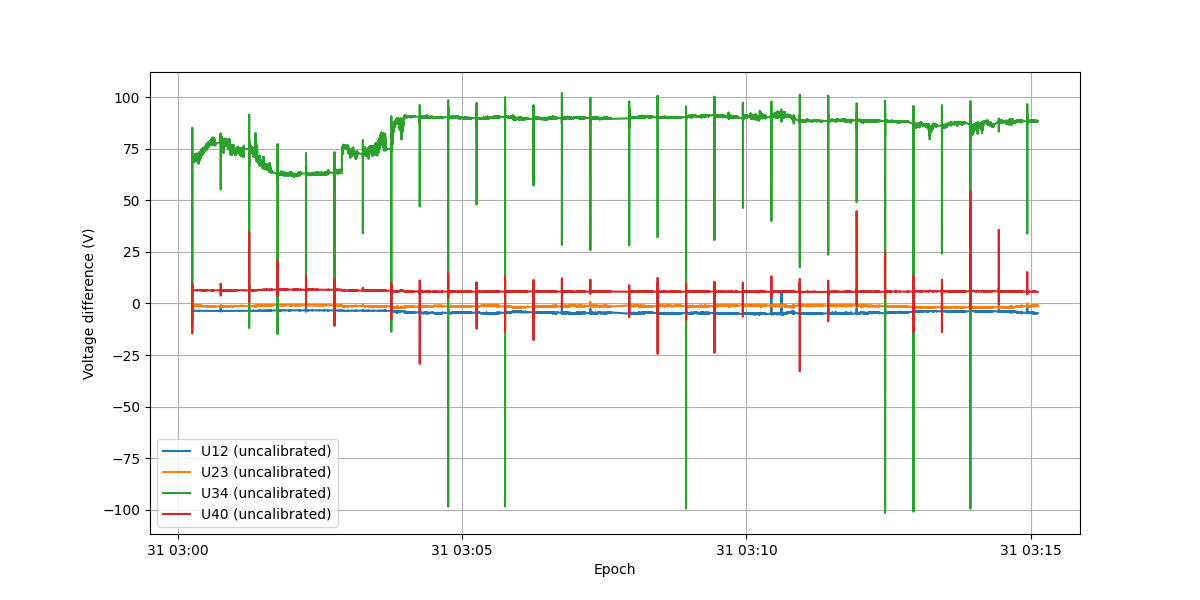

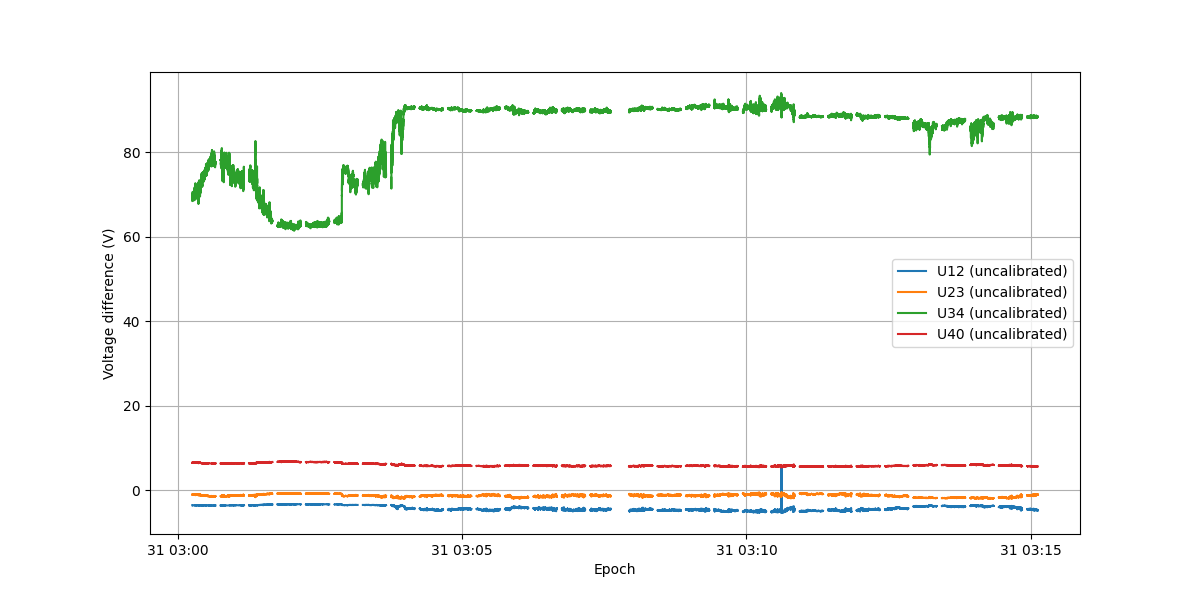

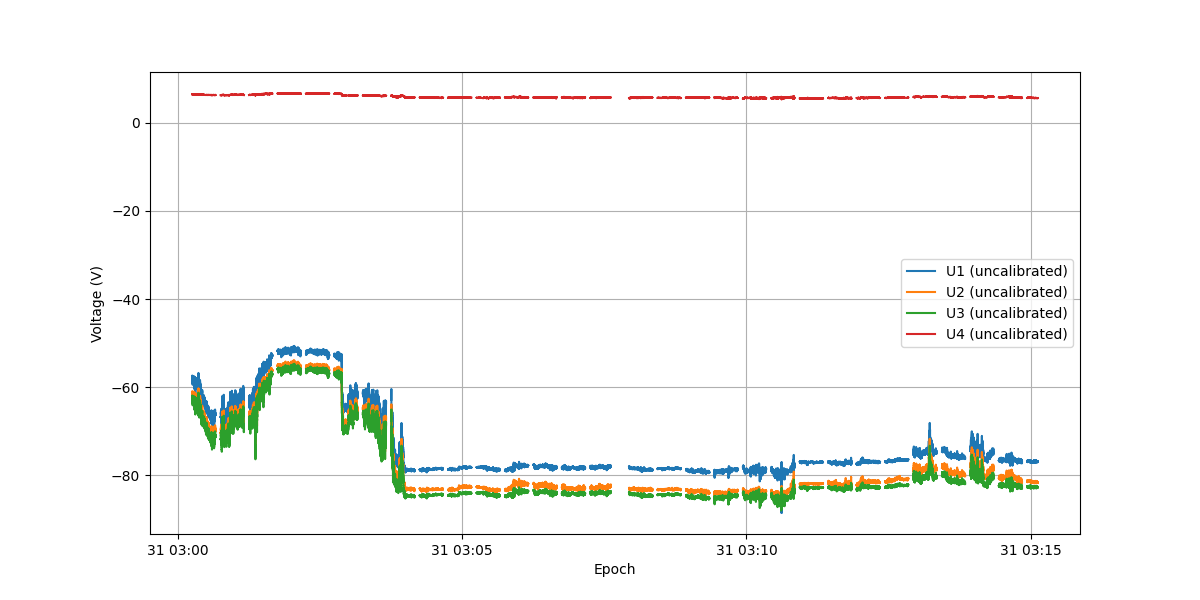

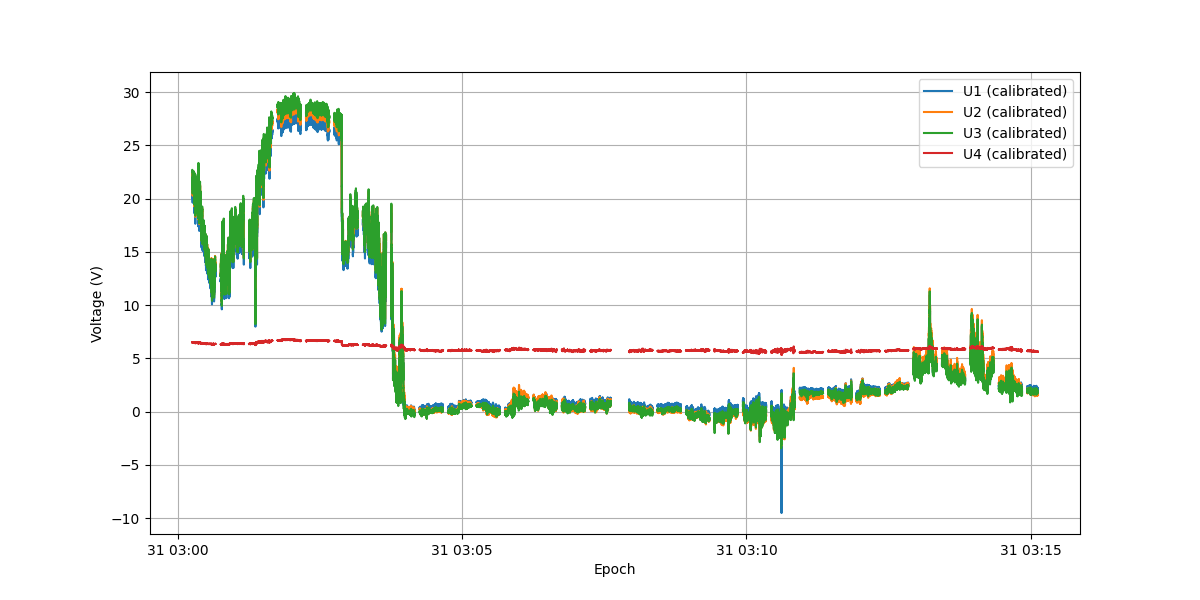

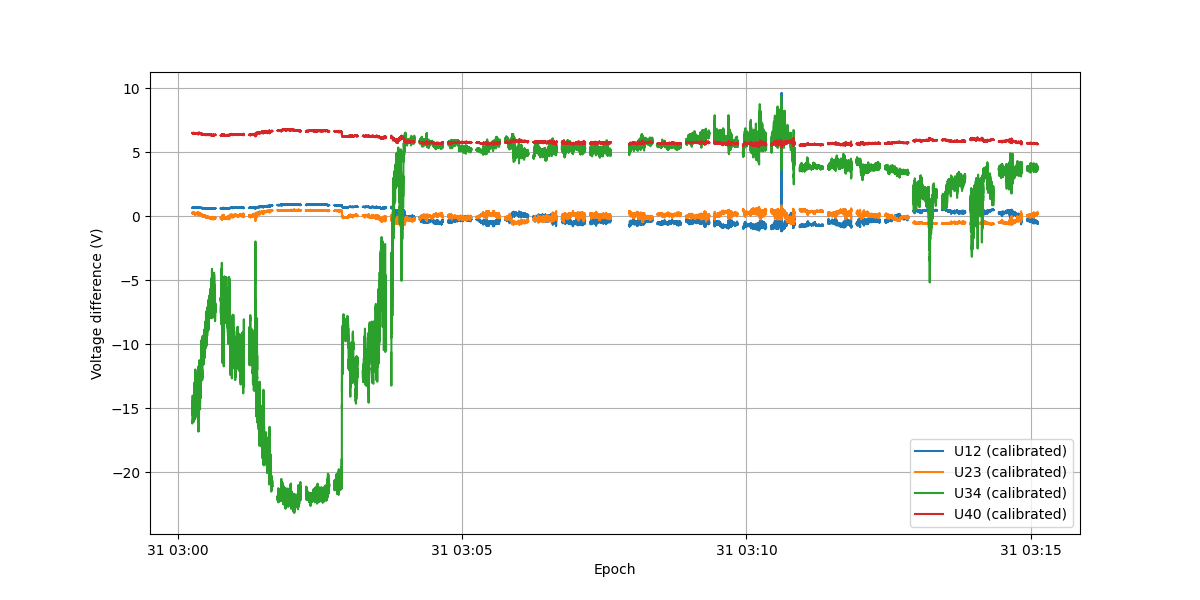

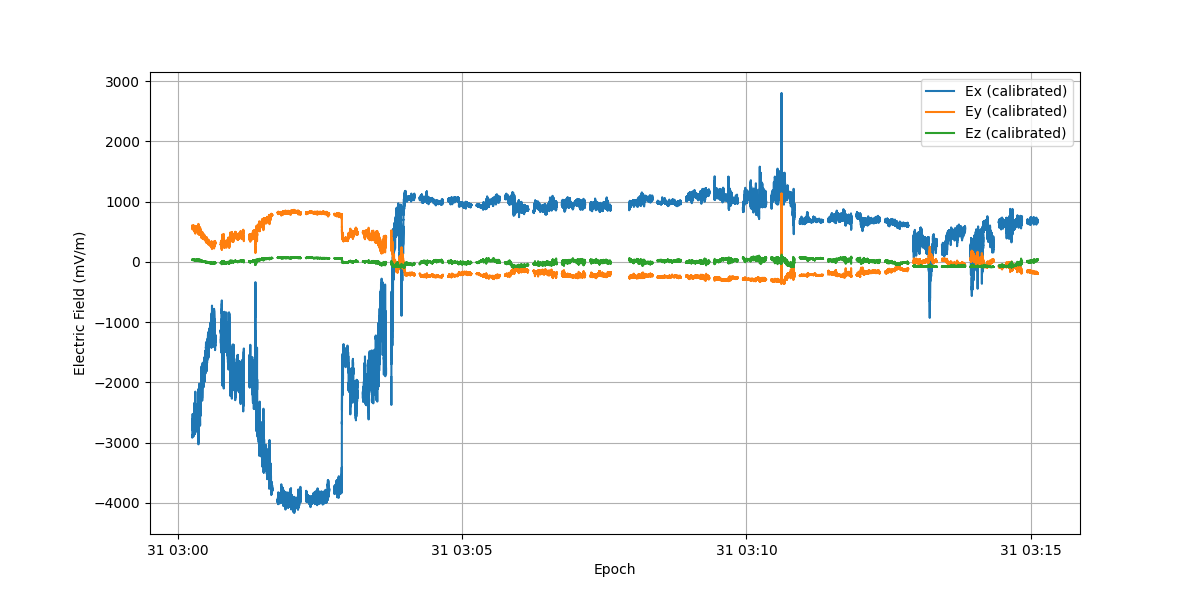

In [23]:
# Getting E field from ENG LP data

nb_final_removed = 11000

"""
lp_cdf = pycdf.CDF('../DATA/JUICE_L1a_RPWI-LP-SID1_RICH_DE763_SNAP_20250331T030011_V02.cdf')

lp_epoch = lp_cdf['Epoch'][...][:-nb_final_removed]

U12 = lp_cdf['LP_DATA_ENG'][:, 0][:-nb_final_removed]
U23 = lp_cdf['LP_DATA_ENG'][:, 1][:-nb_final_removed]
U34 = lp_cdf['LP_DATA_ENG'][:, 2][:-nb_final_removed]
U40 = lp_cdf['LP_DATA_ENG'][:, 3][:-nb_final_removed]
"""

lp_cdf = cdflib.CDF('../DATA/JUICE_L1a_RPWI-LP-SID1_RICH_DE763_SNAP_20250331T030011_V02.cdf')

lp_epoch = lp_cdf.varget('Epoch')[:-nb_final_removed]
U12 = lp_cdf.varget('LP_DATA_ENG')[:, 0][:-nb_final_removed]
U23 = lp_cdf.varget('LP_DATA_ENG')[:, 1][:-nb_final_removed]
U34 = lp_cdf.varget('LP_DATA_ENG')[:, 2][:-nb_final_removed]
U40 = lp_cdf.varget('LP_DATA_ENG')[:, 3][:-nb_final_removed]
lp_epoch = np.array([REF_DATE + dt.timedelta(seconds=epoch/1e9) for epoch in lp_epoch])

plt.figure(figsize=(12, 6))
plt.plot(lp_epoch, U12, label='U12 (uncalibrated)')
plt.plot(lp_epoch, U23, label='U23 (uncalibrated)')
plt.plot(lp_epoch, U34, label='U34 (uncalibrated)')
plt.plot(lp_epoch, U40, label='U40 (uncalibrated)')
plt.xlabel('Epoch')
plt.ylabel('Voltage difference (V)')
plt.legend()
plt.grid()
plt.show()

U12 = filter_out_start_config_noise(U12, lp_epoch)
U23 = filter_out_start_config_noise(U23, lp_epoch)
U34 = filter_out_start_config_noise(U34, lp_epoch)
U40 = filter_out_start_config_noise(U40, lp_epoch)

plt.figure(figsize=(12, 6))
plt.plot(lp_epoch, U12, label='U12 (uncalibrated)')
plt.plot(lp_epoch, U23, label='U23 (uncalibrated)')
plt.plot(lp_epoch, U34, label='U34 (uncalibrated)')
plt.plot(lp_epoch, U40, label='U40 (uncalibrated)')
plt.xlabel('Epoch')
plt.ylabel('Voltage difference (V)')
plt.legend()
plt.grid()
plt.show()

U1, U2, U3, U4 = multiply_lists_by_44matrix(U12, U23, U34, U40, delta2volt)

plt.figure(figsize=(12, 6))
plt.plot(lp_epoch, U1, label='U1 (uncalibrated)')
plt.plot(lp_epoch, U2, label='U2 (uncalibrated)')
plt.plot(lp_epoch, U3, label='U3 (uncalibrated)')
plt.plot(lp_epoch, U4, label='U4 (uncalibrated)')
plt.xlabel('Epoch')
plt.ylabel('Voltage (V)')
plt.legend()
plt.grid()
plt.show()

mean_diff_U1 = np.nanmean(np.array(U4) - np.array(U1))
mean_diff_U2 = np.nanmean(np.array(U4) - np.array(U2))
mean_diff_U3 = np.nanmean(np.array(U4) - np.array(U3))

U1 = np.array([float(u) + float(mean_diff_U1) for u in U1])
U2 = np.array([float(u) + float(mean_diff_U2) for u in U2])
U3 = np.array([float(u) + float(mean_diff_U3) for u in U3])

plt.figure(figsize=(12, 6))
plt.plot(lp_epoch, U1, label='U1 (calibrated)')
plt.plot(lp_epoch, U2, label='U2 (calibrated)')
plt.plot(lp_epoch, U3, label='U3 (calibrated)')
plt.plot(lp_epoch, U4, label='U4 (calibrated)')
plt.xlabel('Epoch')
plt.ylabel('Voltage (V)')
plt.legend()
plt.grid()
plt.show()

U12, U23, U34, U40 = multiply_lists_by_44matrix(U1, U2, U3, U4, volt2delta)

plt.figure(figsize=(12, 6))
plt.plot(lp_epoch, U12, label='U12 (calibrated)')
plt.plot(lp_epoch, U23, label='U23 (calibrated)')
plt.plot(lp_epoch, U34, label='U34 (calibrated)')
plt.plot(lp_epoch, U40, label='U40 (calibrated)')
plt.xlabel('Epoch')
plt.ylabel('Voltage difference (V)')
plt.legend()
plt.grid()
plt.show()

Ex, Ey, Ez = multiply_lists_by_33matrix(U12, U23, U34, volt2E)

plt.figure(figsize=(12, 6))
plt.plot(lp_epoch, Ex*1e3, label='Ex (calibrated)')
plt.plot(lp_epoch, Ey*1e3, label='Ey (calibrated)')
plt.plot(lp_epoch, Ez*1e3, label='Ez (calibrated)')
plt.xlabel('Epoch')
plt.ylabel('Electric Field (mV/m)')
plt.legend()
plt.grid()
plt.show()

#pycdf.CDF.close(lp_cdf)

Ey error: 0.07819179278922761
Ez error: 0.035076277703396296


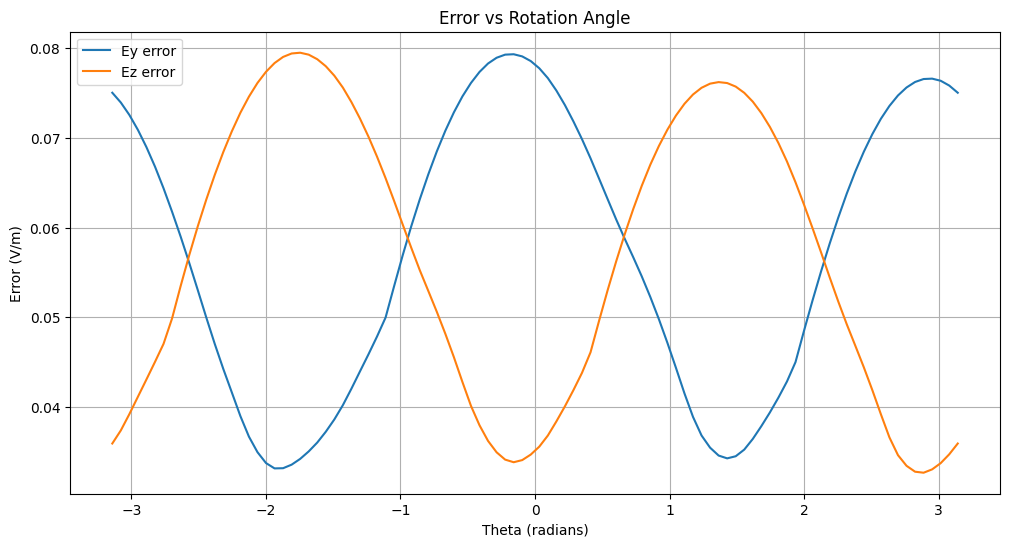

In [167]:
# Seeing which rotation limits the difference between the E fields

def rotate_fields(Ey, Ez, theta):
    Ey_rot = Ey * np.cos(theta) - Ez * np.sin(theta)
    Ez_rot = Ey * np.sin(theta) + Ez * np.cos(theta)
    return Ey_rot, Ez_rot

EyLP = Ey
EzLP =-Ez

# EyvCB = EyvCB
# EzvCB = EzvCB

# Convert all datetime arrays into seconds since March 31st, 2025 at 00:00
reference_time = dt.datetime(2025, 3, 31, 0, 0)

jmag_cdf = pycdf.CDF('../DATA/jmag_echoed/2025/03/31/JUICE_LU_RPWI-PPTD-LWYRPW79710_20250331T030003_V01.cdf')
lp_cdf = pycdf.CDF('../DATA/JUICE_L1a_RPWI-LP-SID1_RICH_DE763_SNAP_20250331T030011_V02.cdf')
jmag_epoch = jmag_cdf['Epoch'][...]
nb_final_removed = 11000
lp_epoch = lp_cdf['Epoch'][...][:-nb_final_removed]

# Convert jmag_epoch and lp_epoch to seconds
jmag_epoch = np.array([(t - reference_time).total_seconds() for t in jmag_epoch])
lp_epoch = np.array([(t - reference_time).total_seconds() for t in lp_epoch])

EyLP = np.interp(jmag_epoch, lp_epoch, EyLP)
EzLP = np.interp(jmag_epoch, lp_epoch, EzLP)

y_error = np.nanmean(np.abs(EyvCB - EyLP))
z_error = np.nanmean(np.abs(EzvCB - EzLP))

print(f"Ey error: {y_error}")
print(f"Ez error: {z_error}")

thetas = np.linspace(-np.pi, np.pi, 100)
y_errors = []
z_errors = []

for theta in thetas:
    Ey_rot, Ez_rot = rotate_fields(EyLP, EzLP, theta)
    y_error = np.nanmean(np.abs(EyvCB - Ey_rot))
    z_error = np.nanmean(np.abs(EzvCB - Ez_rot))
    y_errors.append(y_error)
    z_errors.append(z_error)

plt.figure(figsize=(12, 6))
plt.plot(thetas, y_errors, label='Ey error')
plt.plot(thetas, z_errors, label='Ez error')
plt.xlabel('Theta (radians)')
plt.ylabel('Error (V/m)')
plt.legend()
plt.title('Error vs Rotation Angle')
plt.grid()
plt.show()

pycdf.CDF.close(lp_cdf)
pycdf.CDF.close(jmag_cdf)

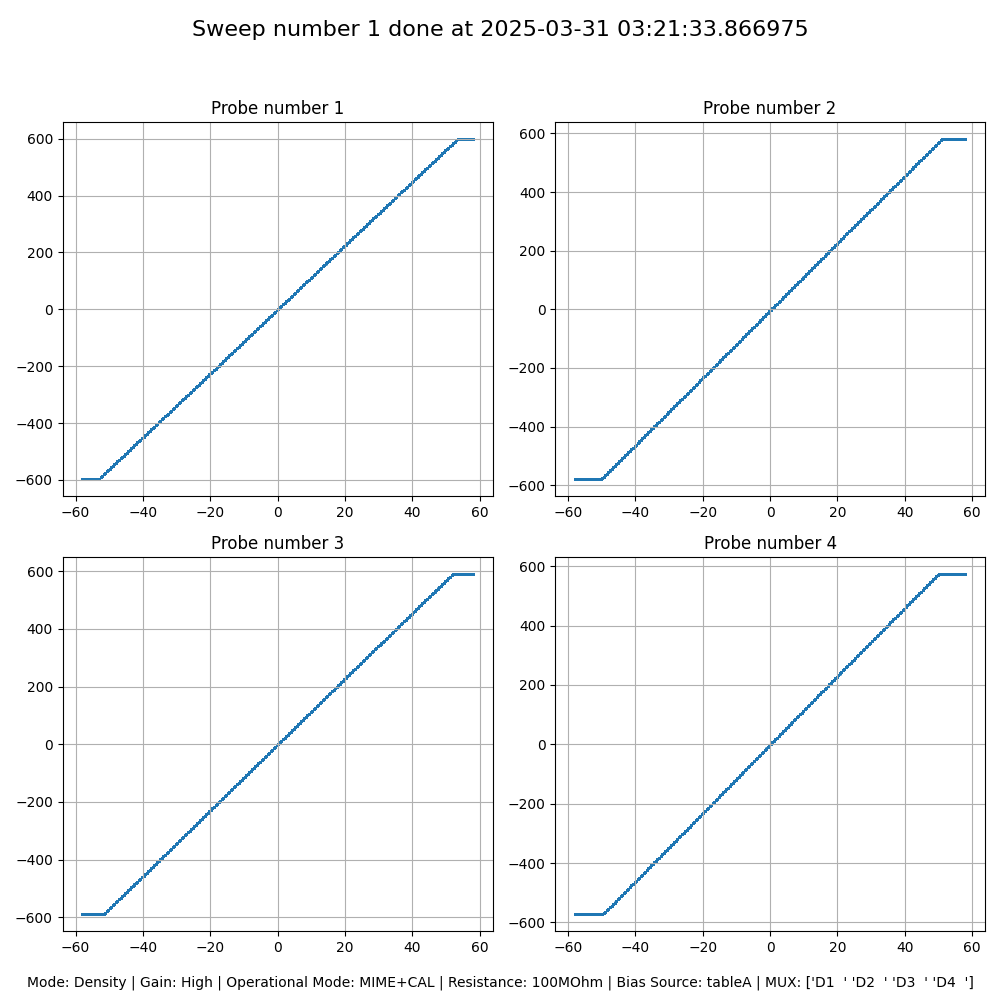

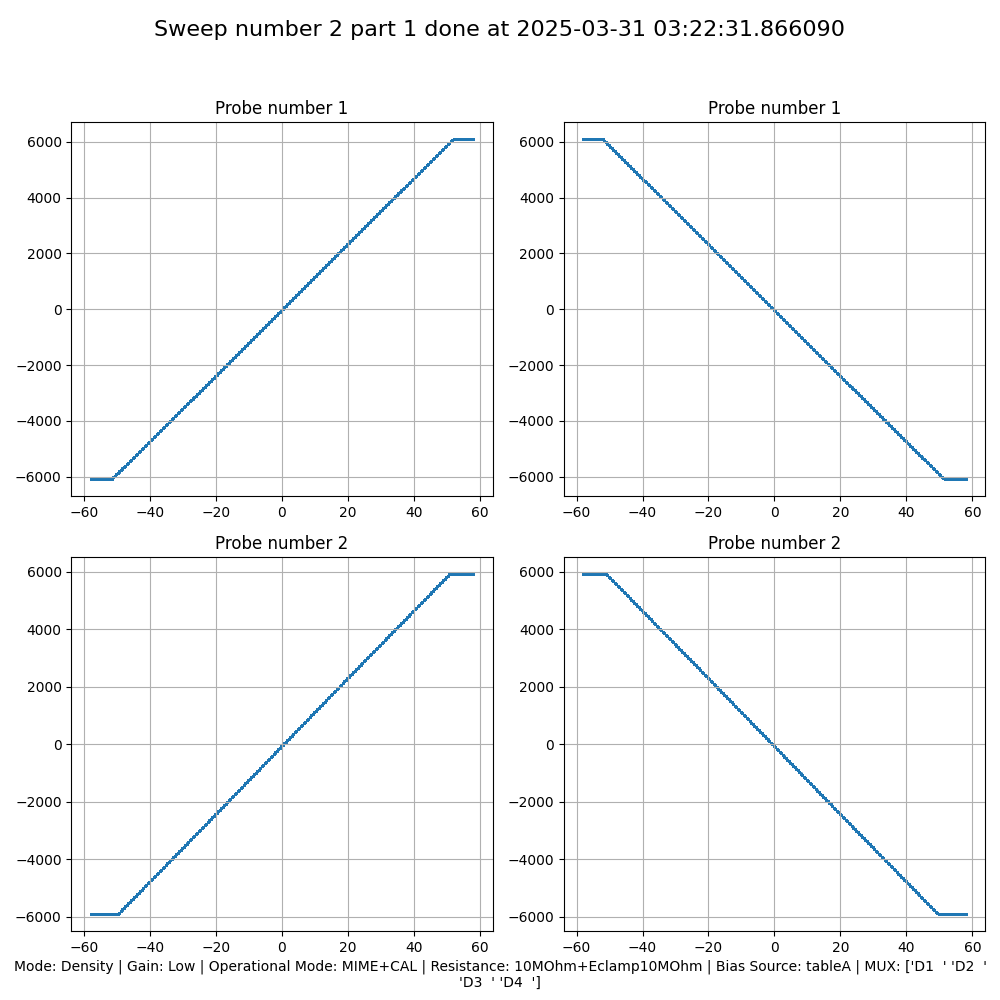

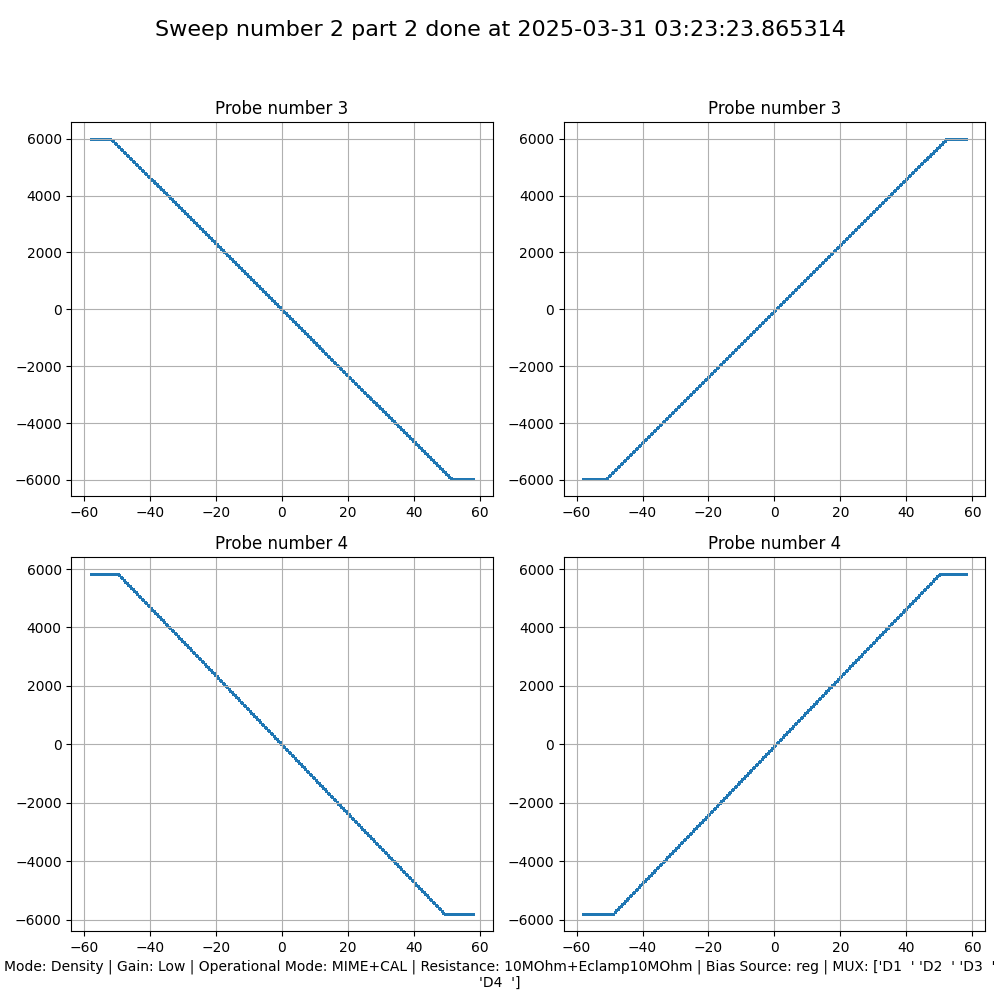

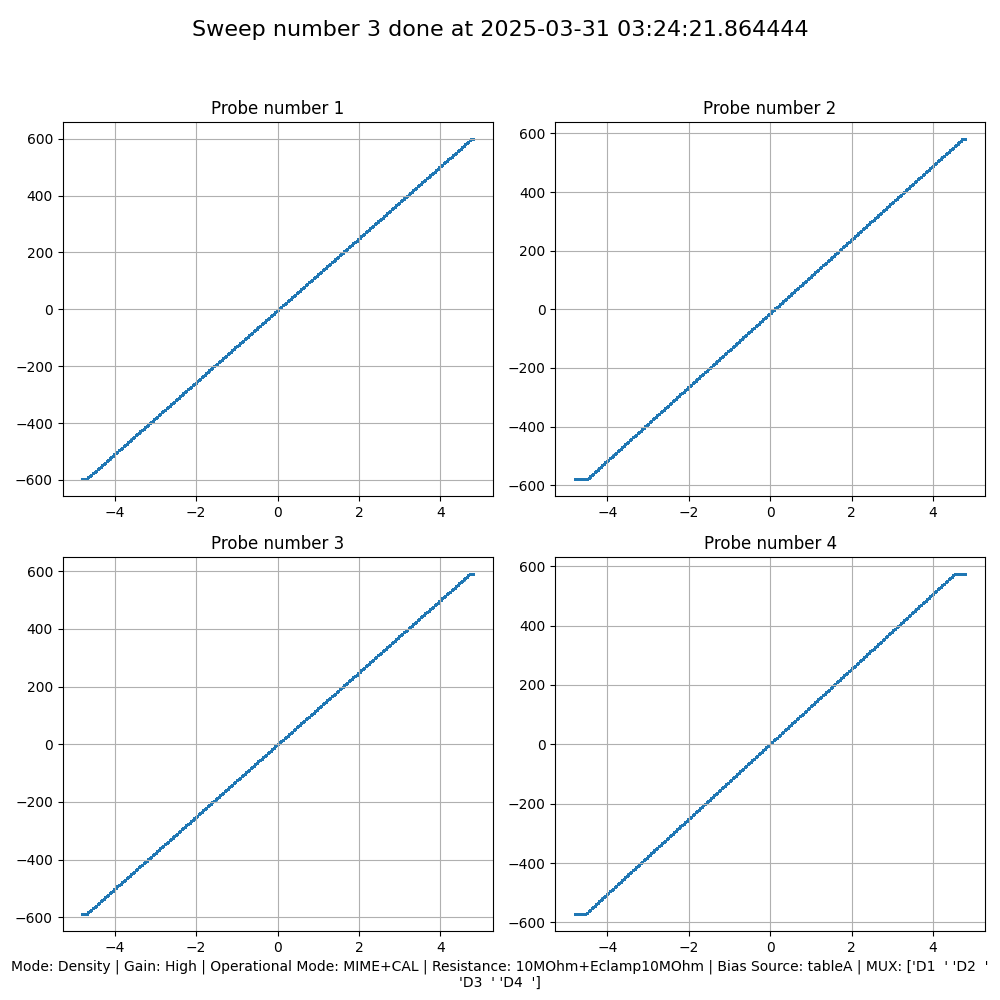

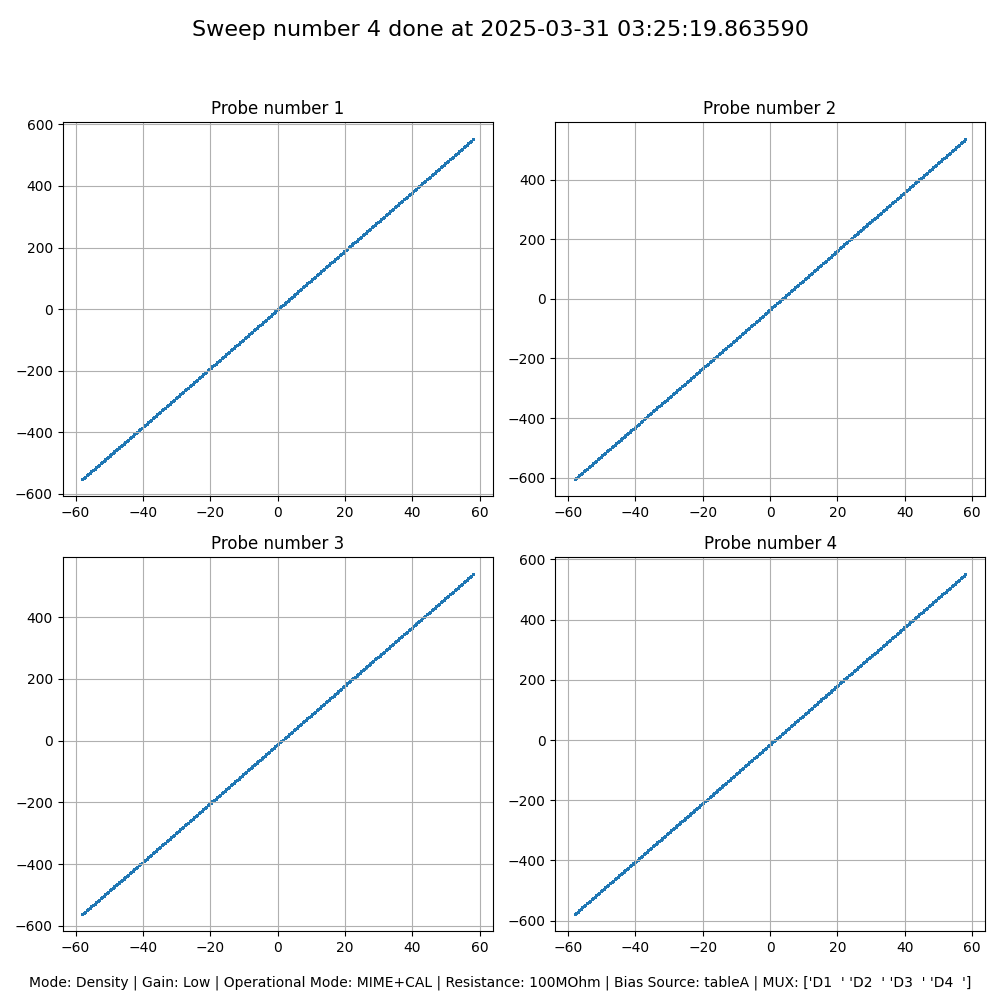

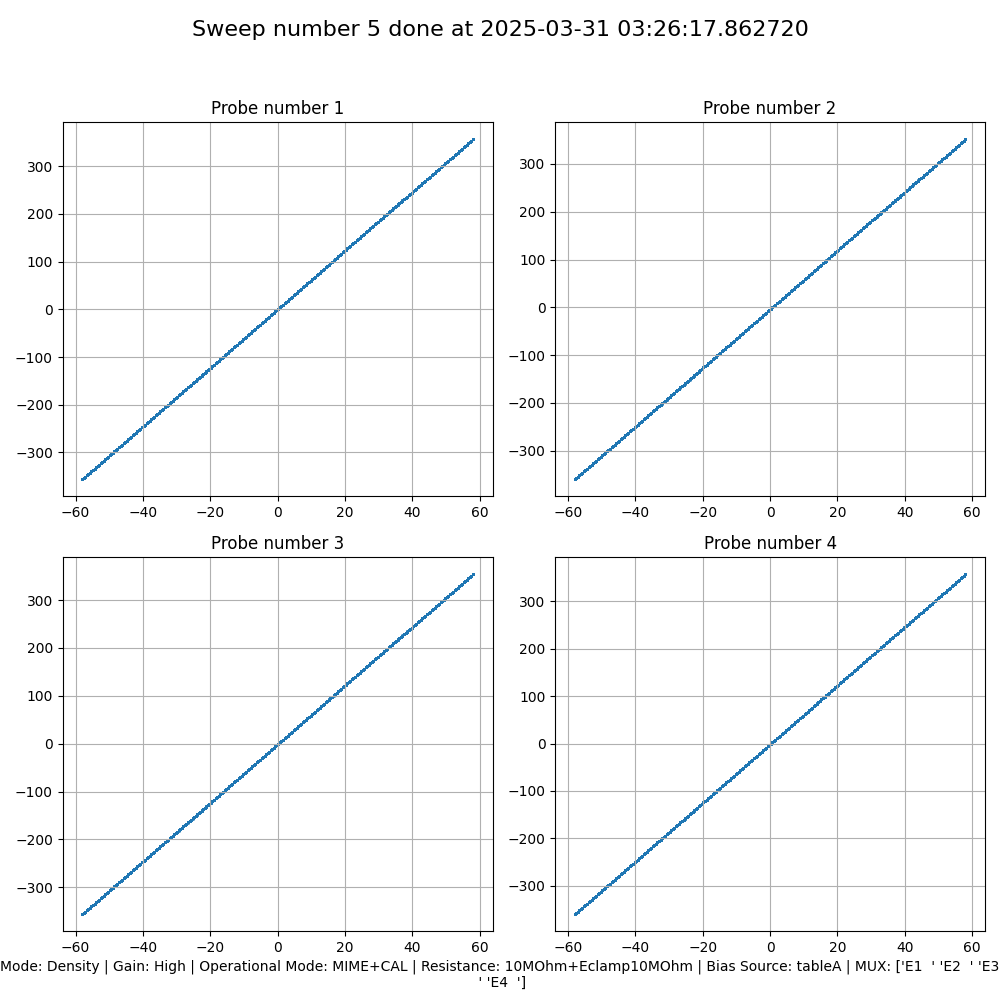

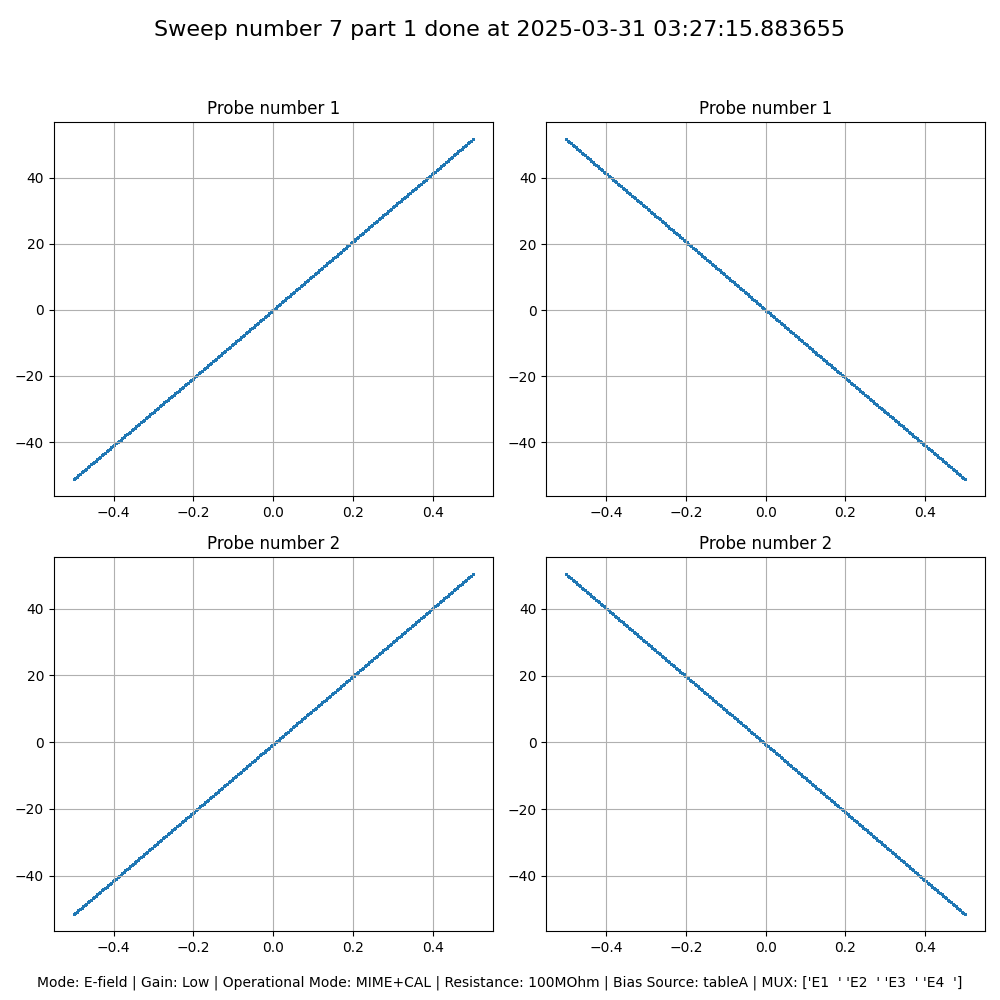

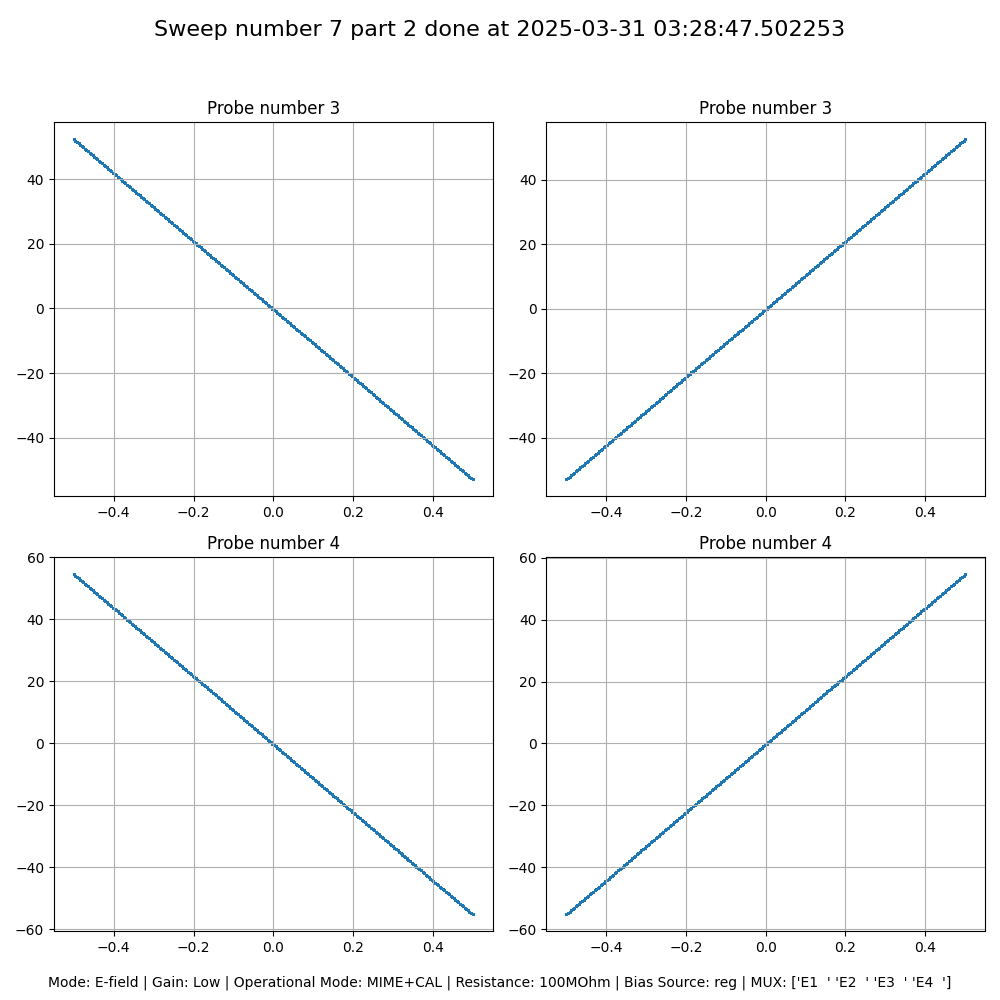

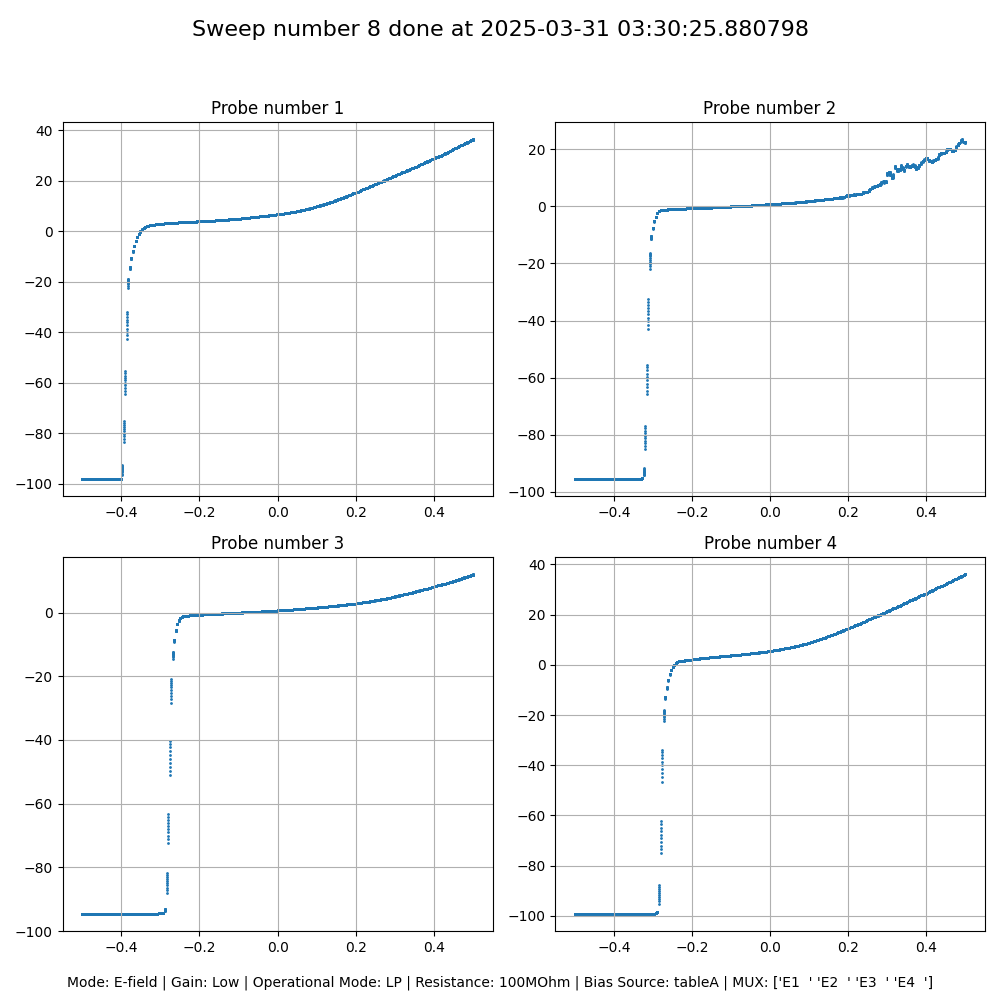

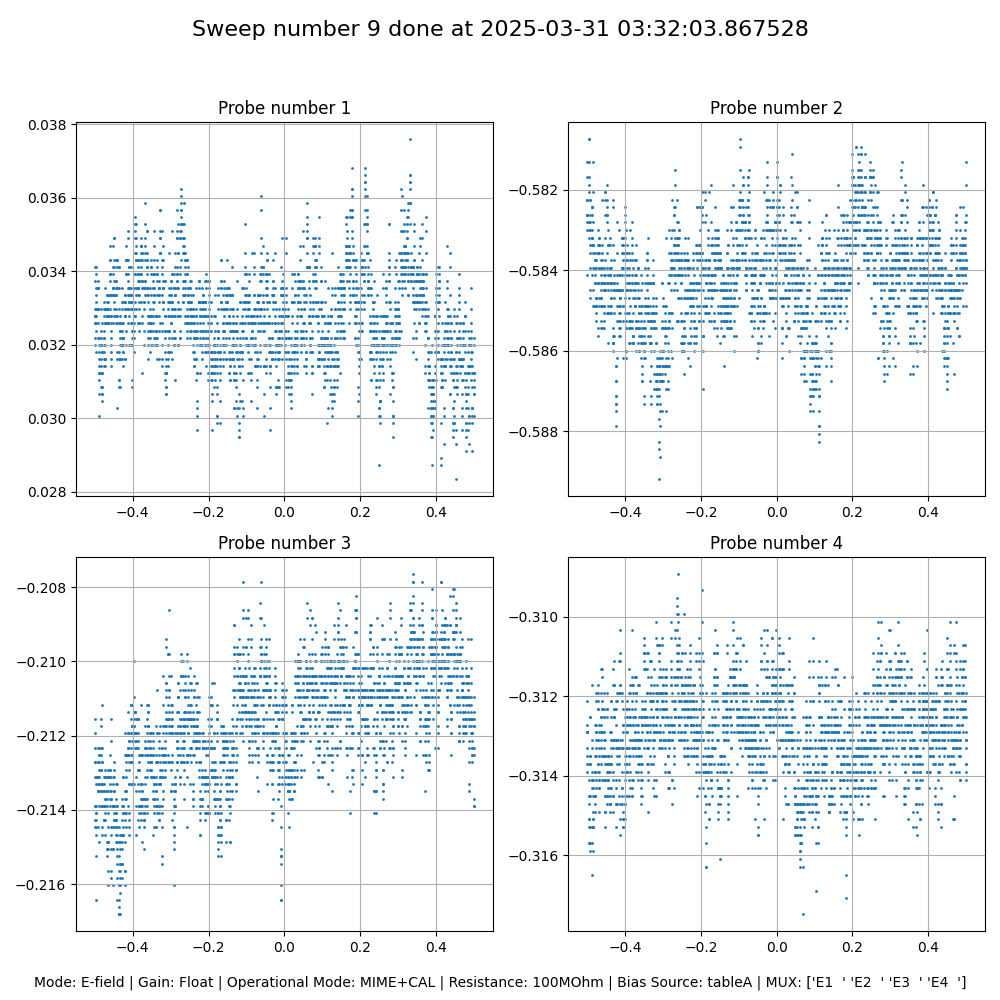

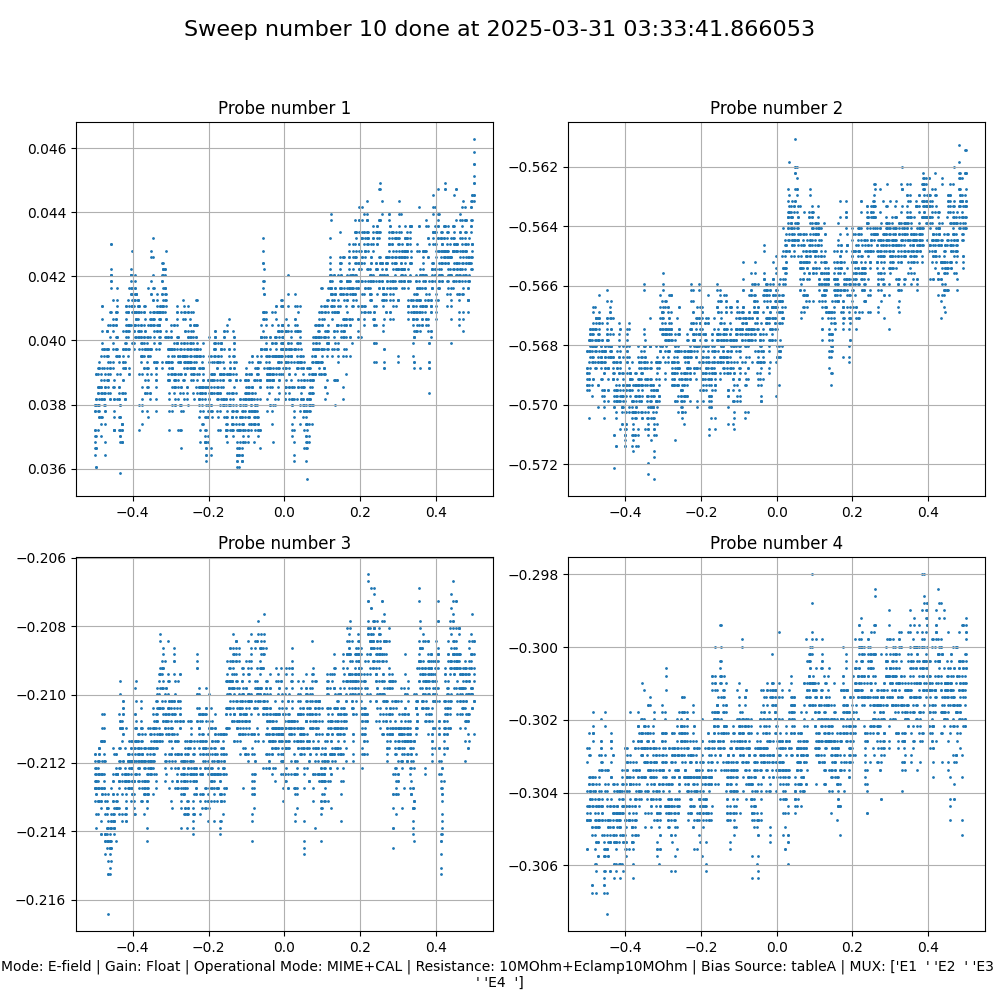

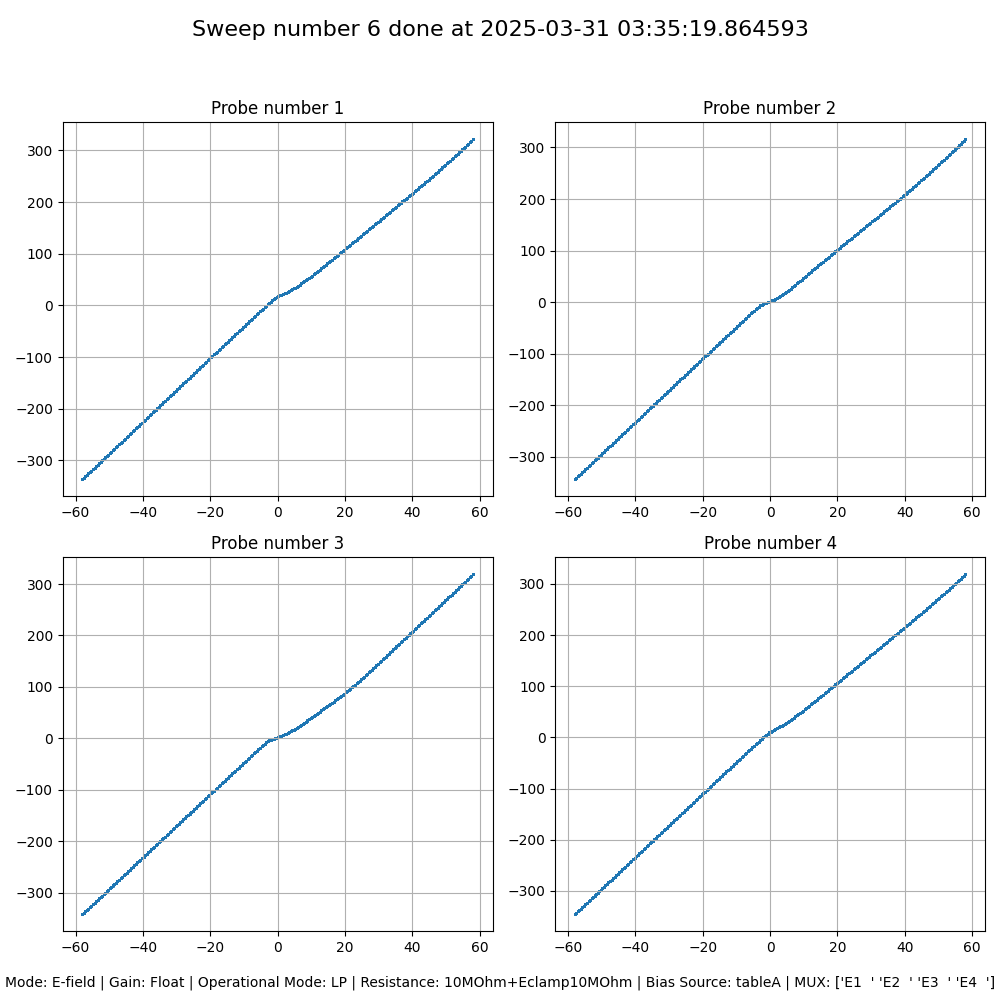

'\n\nfor i in range(nb_sweeps):\n    plt.figure(figsize=(12, 8))\n    plt.suptitle(f"Sweep {i + 1} at {epoch[i]}", fontsize=16)\n\n    for probe in range(4):\n        # get the number of nans in the data i\'m plotting on the y axis\n        nans = np.isnan(filtered_lp_data[i][probe, :])\n        nan_indices = np.where(nans)[0]\n        min_nan_index = nan_indices.min()\n        max_nan_index = nan_indices.max()\n        plt.plot(tables[table_indexes[int(i/4)]], filtered_lp_data[i][probe, :], label=f\'Probe {probe + 1}\')\n\n    plt.legend()\n    plt.grid()\n    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make space for the title\n    plt.show()\n'

In [24]:
# Sweeps (SID 2)
# PROBE_MODES Per probe. 1=E-field, 0=Density. As in RELAY_B_WERG, relay B
# PROBE_GAINS Per probe. 1=Lo, 0=Hi if in Density. 1=current_bias 0=float if in E-field. As in RELAY_B_WERG, relay C
# OPERATIONAL_MODES Per probe. 0=LP, 1=MIME+CAL. As in RELAY_B_WERG, relay A
# PROBE_RESISTANCES Per probe. 1=100MOhm, 0=10MOhm+Eclamp10MOhm. As in RELAY_B_WERG, relay D
# BIAS_SOURCES 0=reg, 1=reg+freq, 2=tableA, 3=tableA+freq, 4=tableB, 5=tableB+freq. As in SWEEPB_WERG, DAC sources

"""
cdf_file = pycdf.CDF('../DATA/JUICE_L1a_RPWI-LP-SID2_SRVY_SWEEP_20250331T032129_V02.cdf')

epoch = cdf_file['Epoch'][...]
lp_data = cdf_file['LP_DATA_ENG'][...]
bias_data = cdf_file['BIAS_ENG'][...]
mux = cdf_file['ADC_MUX'][...]
probe_mode = cdf_file['PROBE_MODES'][...]
gain = cdf_file['PROBE_GAINS'][...]
operational_mode = cdf_file['OPERATIONAL_MODES'][...]
resistance = cdf_file['PROBE_RESISTANCES'][...]
source = cdf_file['BIAS_SOURCES'][...]
"""

# Modify the tables to have 20 consecutive repetitions of each value, making them 5120 long with 256 distinct numbers
table3A = np.repeat(np.linspace(-58, 58, 256), 10)  # V
table3A = np.tile(table3A, 2)
table3B = np.repeat(np.linspace(58, -58, 256), 10)  # V
table3B = np.tile(table3B, 2)
table0A = np.repeat(np.linspace(-4.8, 4.8, 256), 10)  # V
table0A = np.tile(table0A, 2)
table2A = np.repeat(np.linspace(-0.5, 0.5, 256), 10)  # µA
table2A = np.tile(table2A, 2)
table2B = np.repeat(np.linspace(0.5, -0.5, 256), 10)  # µA
table2B = np.tile(table2B, 2)
tables = [table3A, table3B, table0A, table2A, table2B]

cdf_file = cdflib.CDF('../DATA/JUICE_L1a_RPWI-LP-SID2_SRVY_SWEEP_20250331T032129_V02.cdf')
epoch = cdf_file.varget('Epoch')
lp_data = cdf_file.varget('LP_DATA_ENG')
bias_data = cdf_file.varget('BIAS_ENG')
mux = cdf_file.varget('ADC_MUX')
probe_mode = cdf_file.varget('PROBE_MODES')
gain = cdf_file.varget('PROBE_GAINS')
operational_mode = cdf_file.varget('OPERATIONAL_MODES')
resistance = cdf_file.varget('PROBE_RESISTANCES')
source = cdf_file.varget('BIAS_SOURCES')

# Convert epoch from nanoseconds since J2000 to datetime
epoch = [REF_DATE + dt.timedelta(seconds=t / 1e9) for t in epoch]

nb_sweeps = len(lp_data)

# Reshaping lp_data to extract 48 arrays of size 4*5120
filtered_lp_data = [lp_data[i, :, :] for i in range(nb_sweeps)]

# Reshaping bias_data to extract 48 arrays of size 4*5120
filtered_bias_data = [bias_data[i, :, :] for i in range(nb_sweeps)]

filtered_lp_data = [np.where(np.abs(data) > 1e10, np.nan, data) for data in filtered_lp_data]

filtered_bias_data = [np.where(np.abs(data) > 1e10, np.nan, data) for data in filtered_bias_data]

sweep_titles = ['1', '2 part 1', '2 part 2', '3', '4', '5', '7 part 1', '7 part 2', '8', '9', '10', '6']
table_indexes = [0, 0, 1, 2, 0, 0, 3, 4, 3, 3, 3, 0]
probe_def = [0,1,2,3]
probe_a = [0,0,1,1]
probe_b = [2,2,3,3]


for i in range(nb_sweeps // 4):

    if i in [1, 6]:
        probe_list = probe_a
    elif i in [2, 7]:
        probe_list = probe_b
    else:
        probe_list = probe_def

    probe_mode_text = "E-field" if probe_mode[4*i, 0] == 1 else "Density"
    gain_text = "Low" if gain[4*i, 0] == 1 else "High" if probe_mode[4*i, 0] == 0 else "Current Bias" if gain[4*i, 0] == 1 else "Float"
    operational_mode_text = "MIME+CAL" if operational_mode[4*i, 0] == 1 else "LP"
    resistance_text = "100MOhm" if resistance[4*i, 0] == 1 else "10MOhm+Eclamp10MOhm"
    source_text = {
        0: "reg",
        1: "reg+freq",
        2: "tableA",
        3: "tableA+freq",
        4: "tableB",
        5: "tableB+freq"
    }.get(source[4*i, 0], "Unknown")
    mux_text = mux[4*i, :]

    metadata = (
        f"Mode: {probe_mode_text} | "
        f"Gain: {gain_text} | "
        f"Operational Mode: {operational_mode_text} | "
        f"Resistance: {resistance_text} | "
        f"Bias Source: {source_text} | "
        f"MUX: {mux_text}"
    )

    plt.figure(figsize=(10, 10))
    plt.suptitle(f"Sweep number {sweep_titles[i]} done at {epoch[4*i]}", fontsize=16)

    for probe in range(4):
        # Perform linear regression
        #valid_indices = ~np.isnan(filtered_bias_data[4*i+probe][probe_list[probe], :]) & ~np.isnan(filtered_lp_data[4*i+probe][probe_list[probe], :])
        #x = filtered_bias_data[4*i+probe][probe_list[probe], :][valid_indices]
        #y = filtered_lp_data[4*i+probe][probe_list[probe], :][valid_indices]
        
        #coeffs = np.polyfit(x, y, 1)  # Linear regression (degree 1)
        #fit_line = np.polyval(coeffs, x)
        # Calculate R-squared
        #residuals = y - fit_line
        #ss_res = np.sum(residuals**2)
        #ss_tot = np.sum((y - np.mean(y))**2)
        #r_squared = 1 - (ss_res / ss_tot)

        # Plotting the data for the probe
        plt.subplot(2, 2, probe + 1)
        plt.title(f'Probe number {probe_list[probe] + 1}')
        
        plt.scatter(tables[table_indexes[i]], filtered_lp_data[4*i + probe][probe_list[probe], :], s=1)
        #plt.plot(x, fit_line, color='red', label=f'Fit: y = {coeffs[0]:.6f}x + {coeffs[1]:.6f} R^2 = {r_squared}', alpha=0.5)
        plt.grid()

    # Add metadata at the bottom of the figure
    plt.figtext(0.5, 0.01, metadata, ha='center', va='bottom', fontsize=10, wrap=True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make space for metadata
    plt.show()
"""

for i in range(nb_sweeps):
    plt.figure(figsize=(12, 8))
    plt.suptitle(f"Sweep {i + 1} at {epoch[i]}", fontsize=16)

    for probe in range(4):
        # get the number of nans in the data i'm plotting on the y axis
        nans = np.isnan(filtered_lp_data[i][probe, :])
        nan_indices = np.where(nans)[0]
        min_nan_index = nan_indices.min()
        max_nan_index = nan_indices.max()
        plt.plot(tables[table_indexes[int(i/4)]], filtered_lp_data[i][probe, :], label=f'Probe {probe + 1}')

    plt.legend()
    plt.grid()
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make space for the title
    plt.show()
"""

#pycdf.CDF.close(cdf_file)

Global attribute: Data_type = ['H0>High Resolution data']
Global attribute: Data_version = ['1']
Global attribute: Dataset_ID = ['JUICE_L1a_RPWI-LP-SID9_SRVY_SWEEP_DSW']
Global attribute: Descriptor = ['RPWI>Radio & Plasma Waves Investigation']
Global attribute: Discipline = ['Planetary Physics>Fields']
Global attribute: File_naming_convention = ['source_descriptor_datatype_yyyyMMdd']
Global attribute: Generated_by = ['IRF-U']
Global attribute: Generated_with_software = ['RPWI main tm2raw s/w']
Global attribute: Generation_date = ['20250411']
Global attribute: Generation_time_UTC = ['2025-04-11T12:38:19Z']
Global attribute: git_log_message_DC = ['4d12fed Thomas Nilsson (2024-08-21 17:38:28 +0200) (HEAD -> master, origin/master, origin/HEAD) Add correction by Keith (with our standard format)']
Global attribute: git_log_message_HF = ["71bed8c Yasumasa Kasaba (2025-03-08 13:11:29 +0000) (HEAD -> master, tag: v0.7.1, origin/master, origin/HEAD) Merge branch 'develop' into 'master'"]
Global

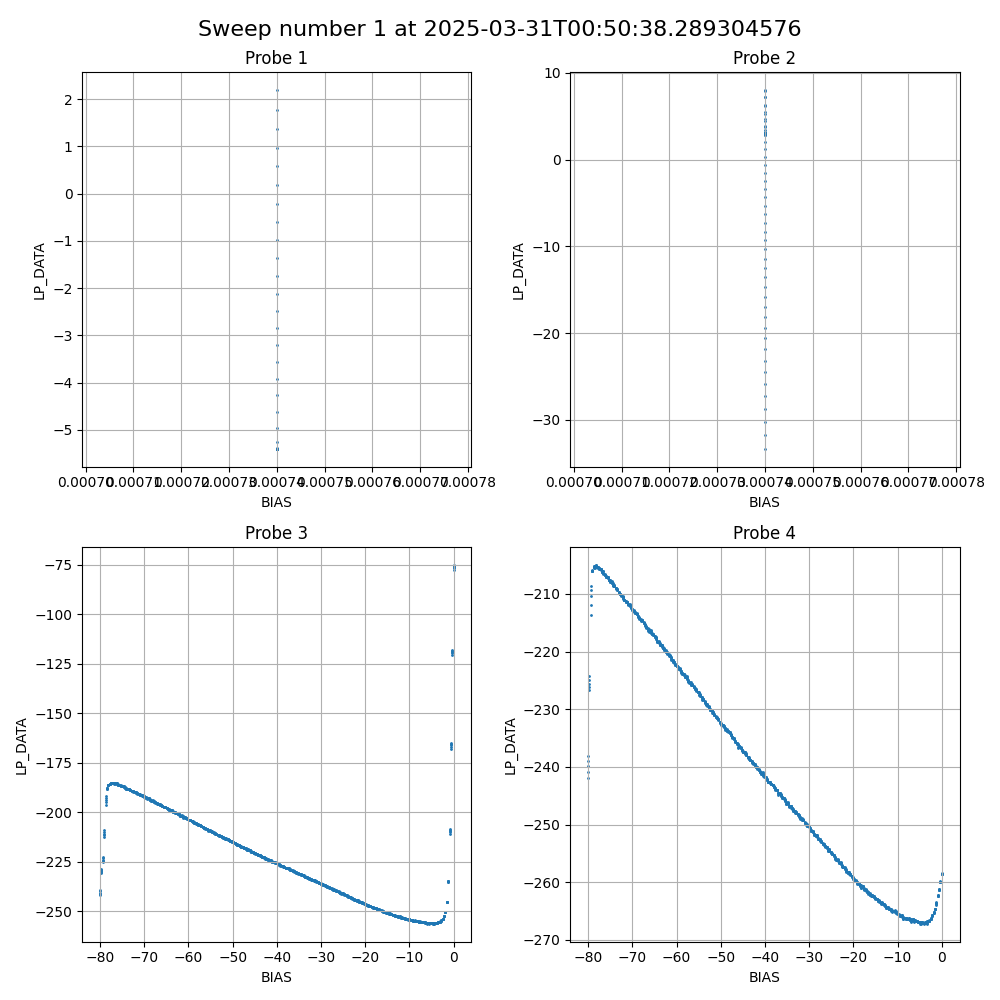

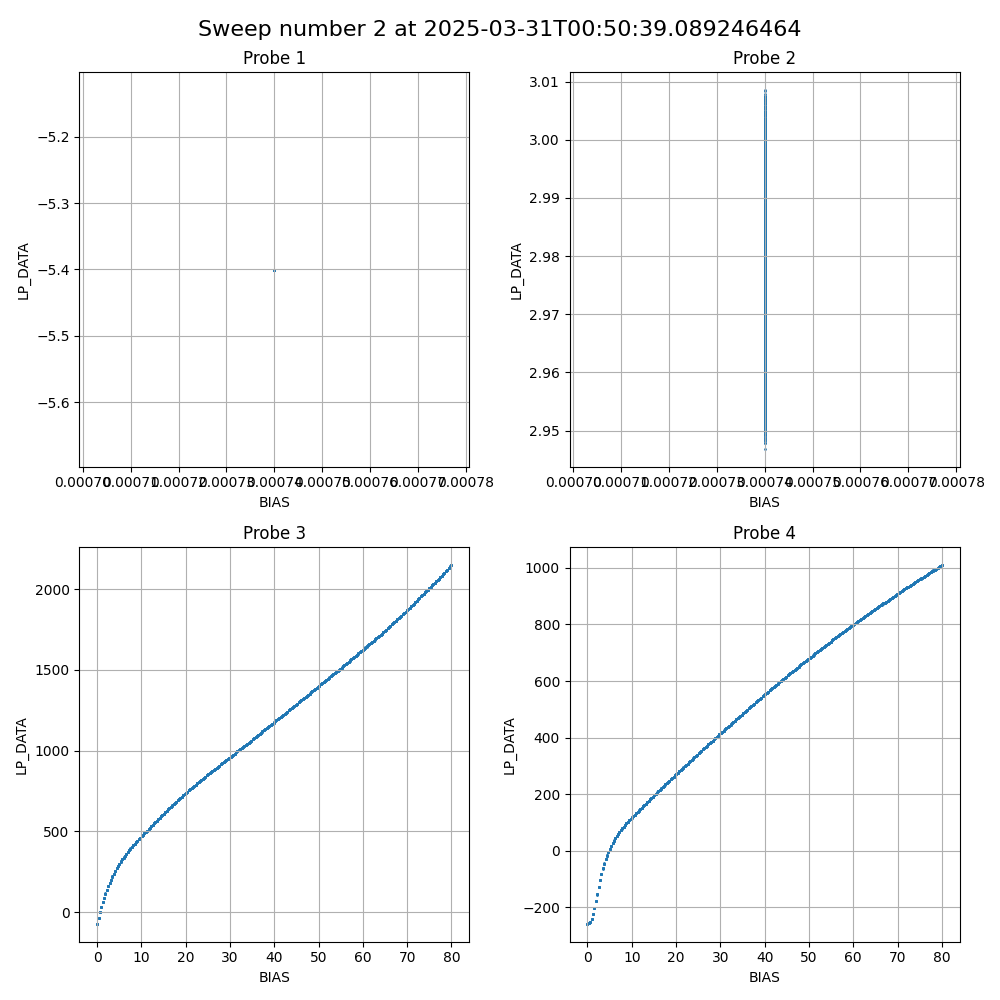

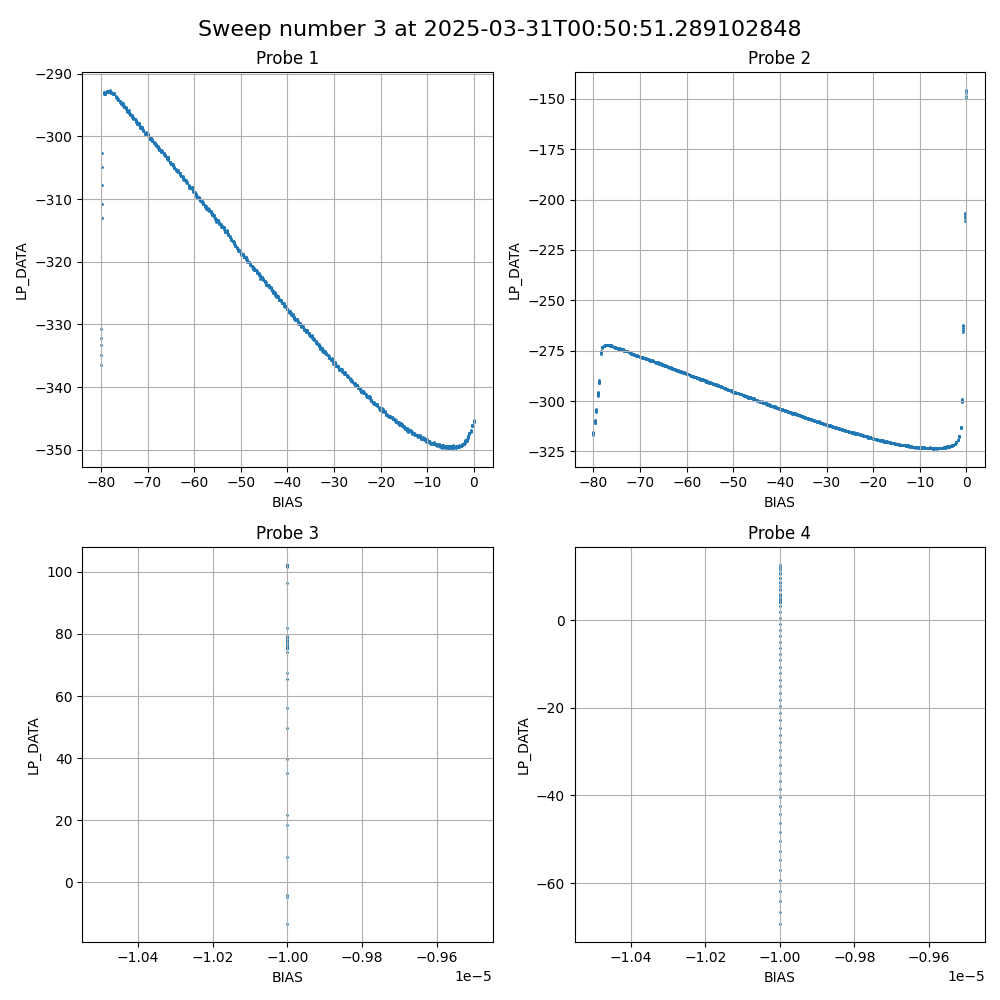

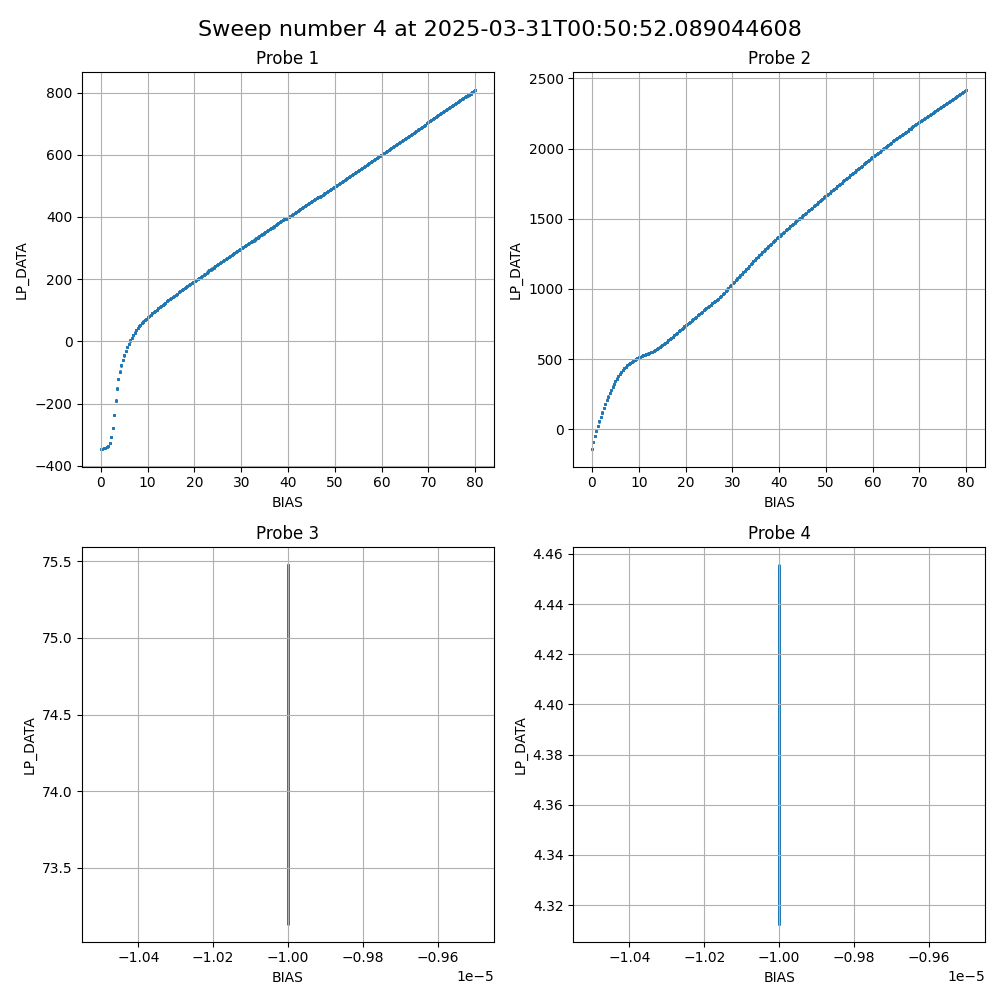

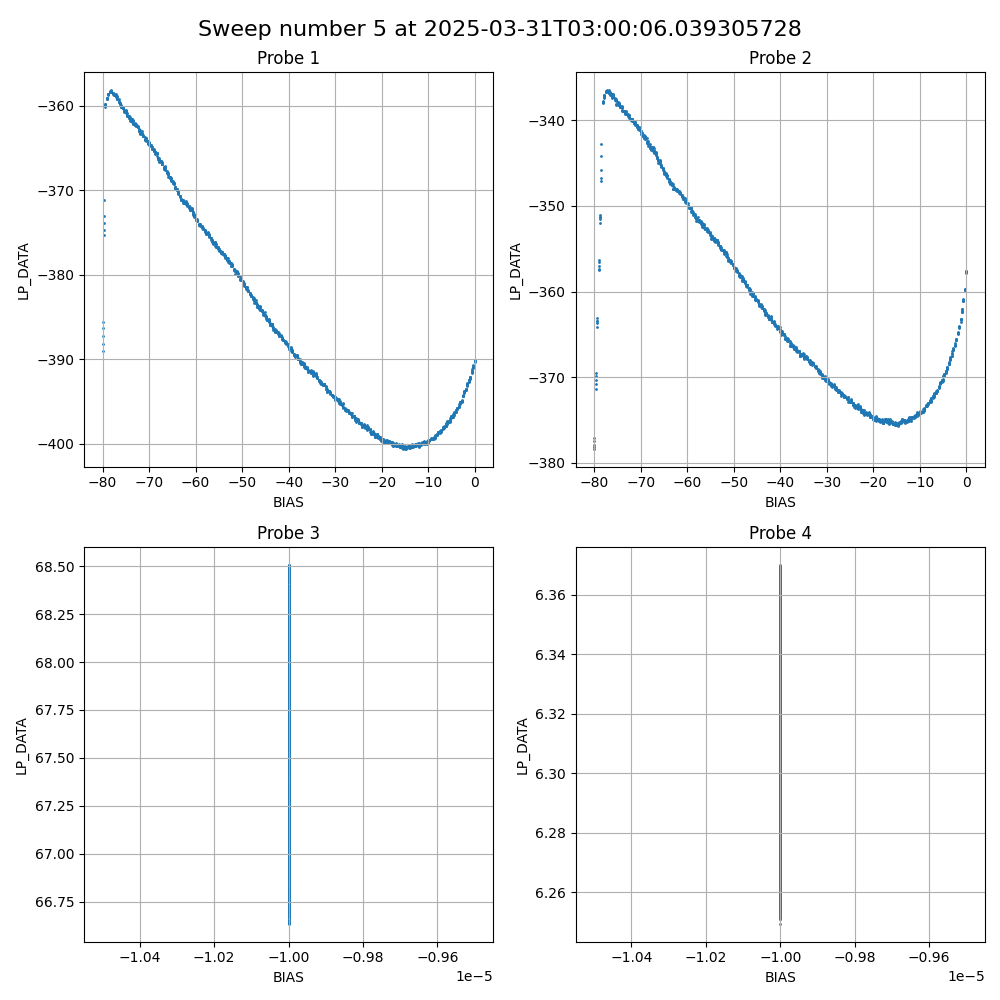

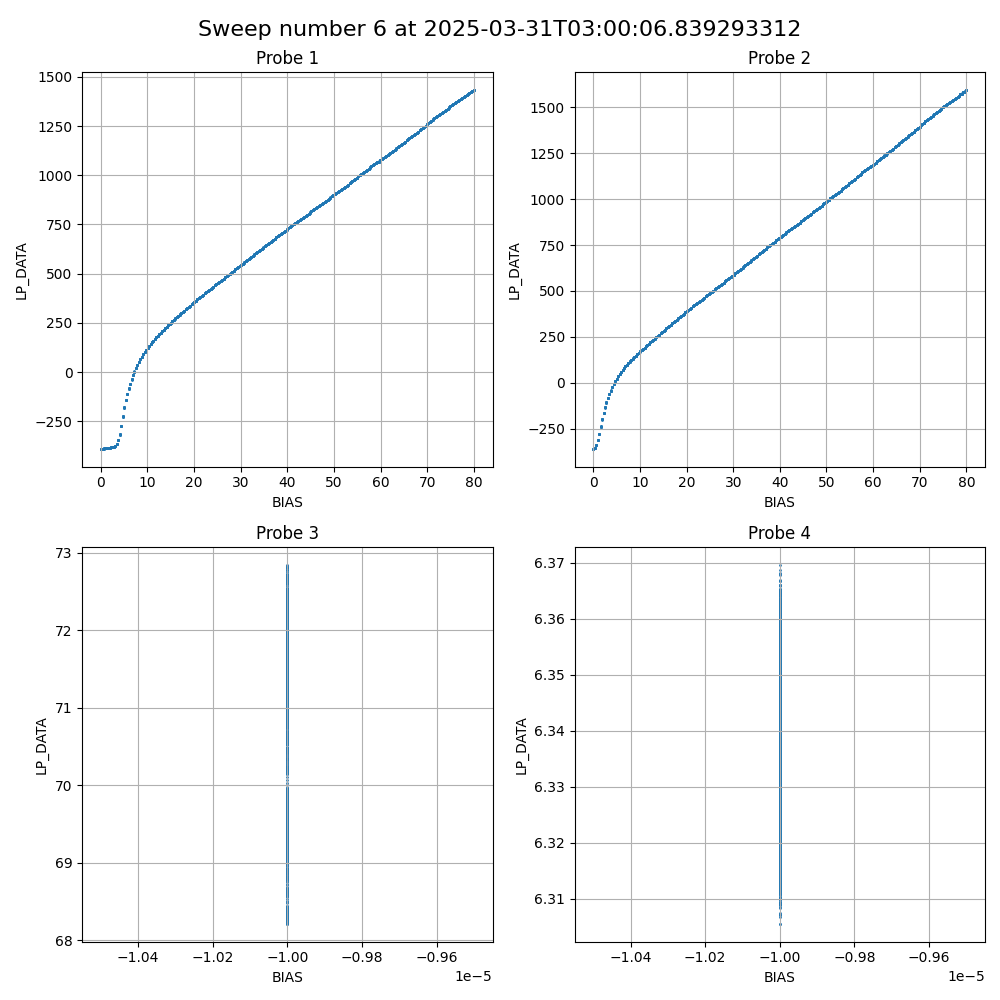

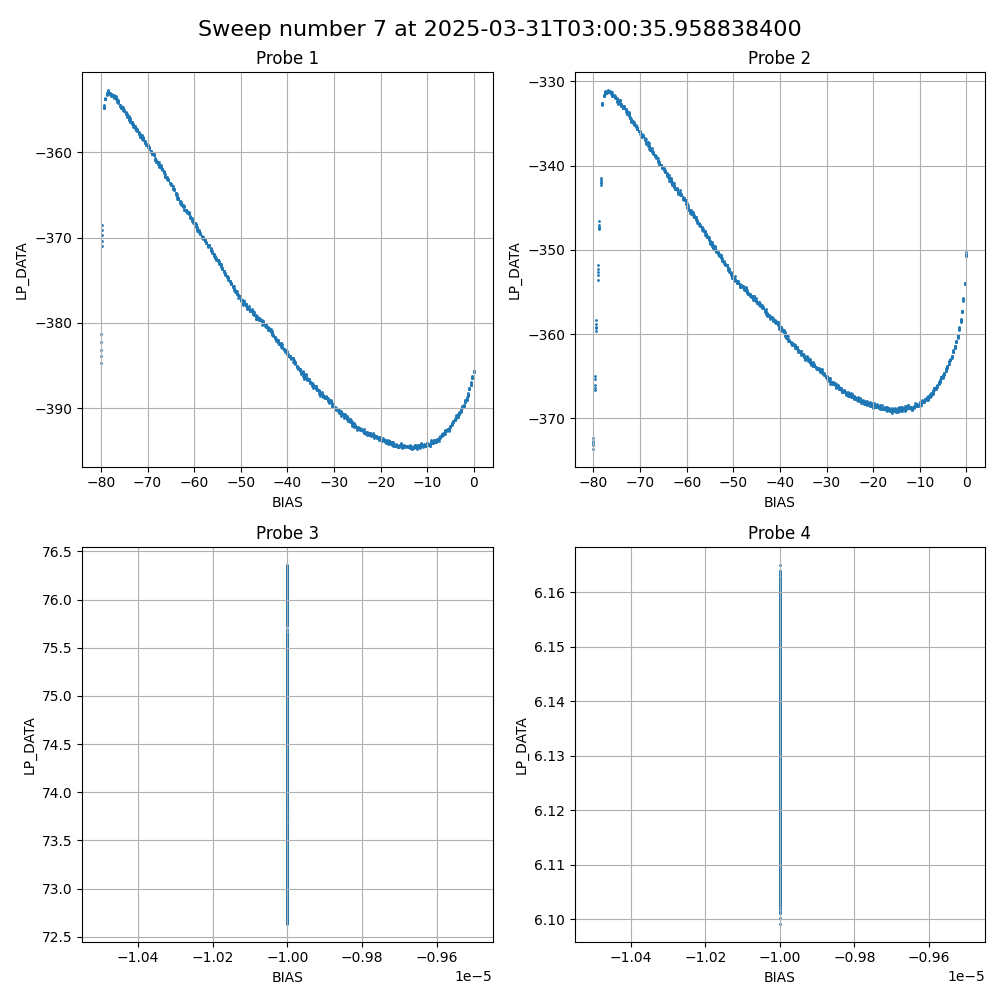

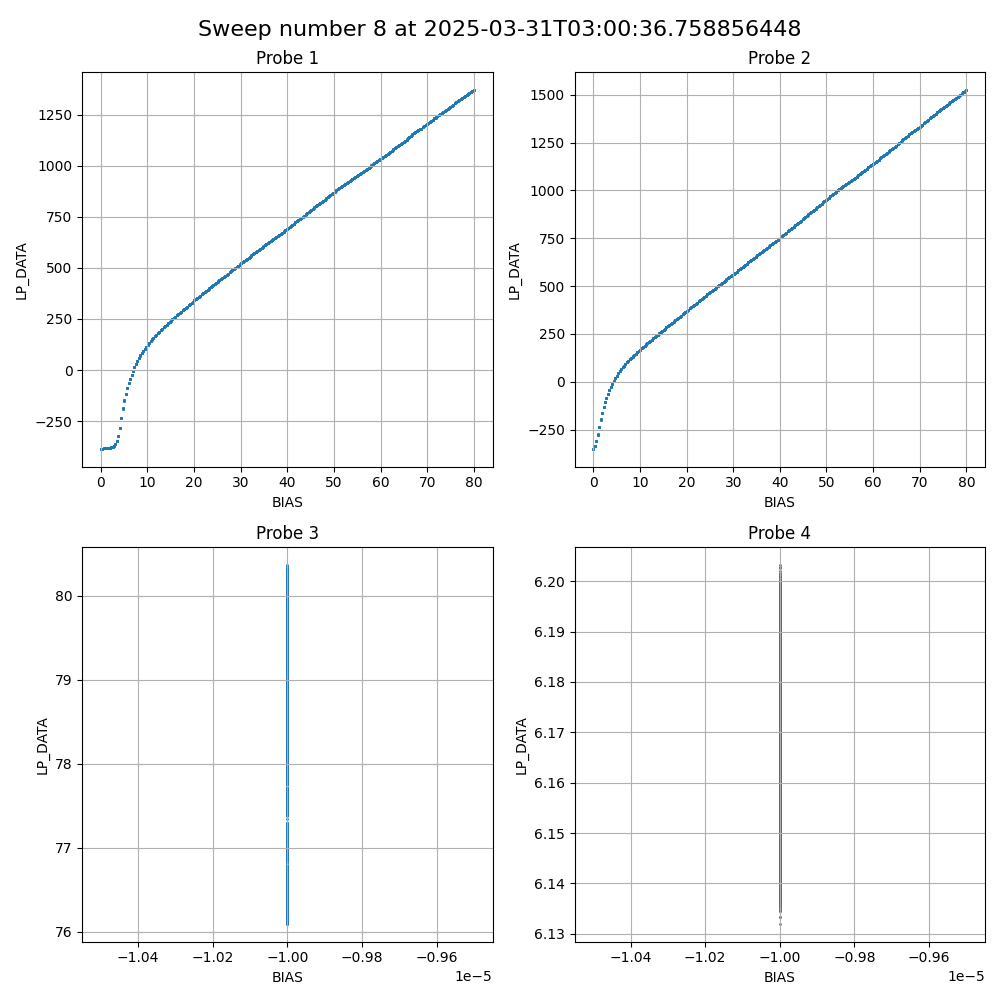

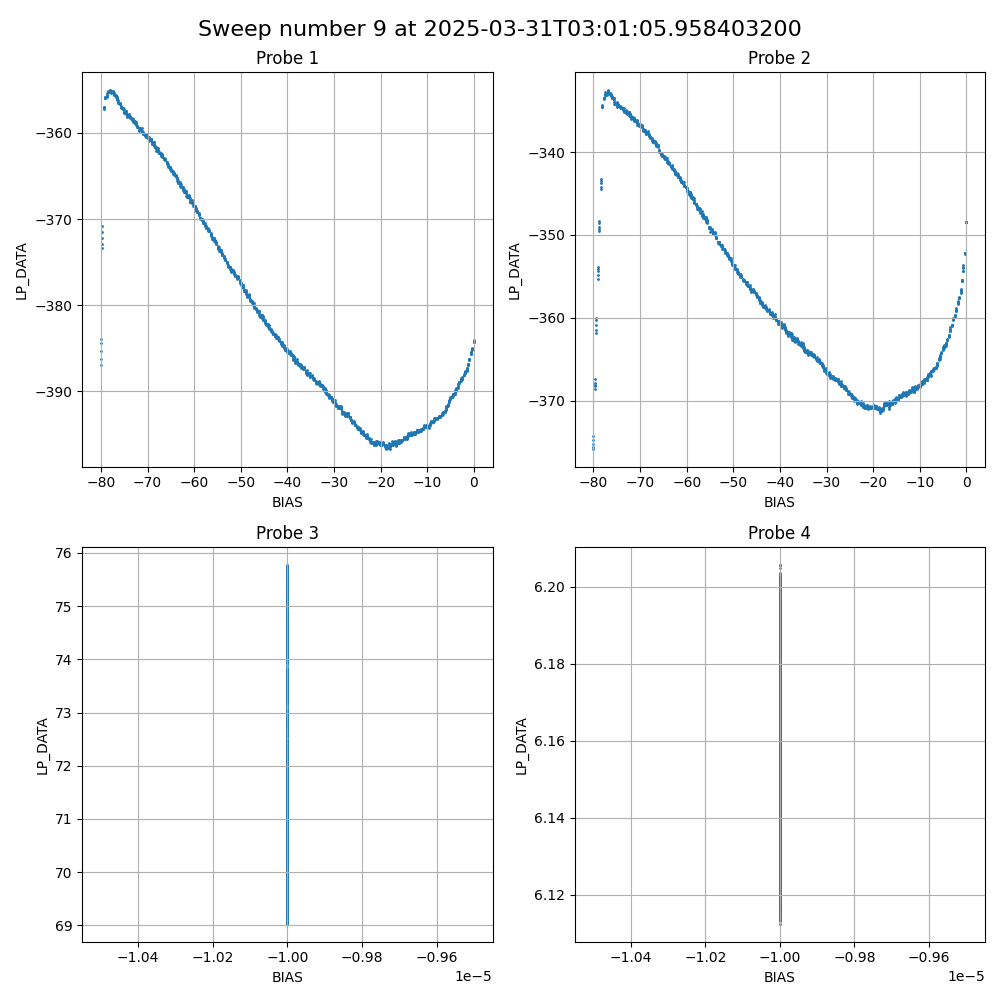

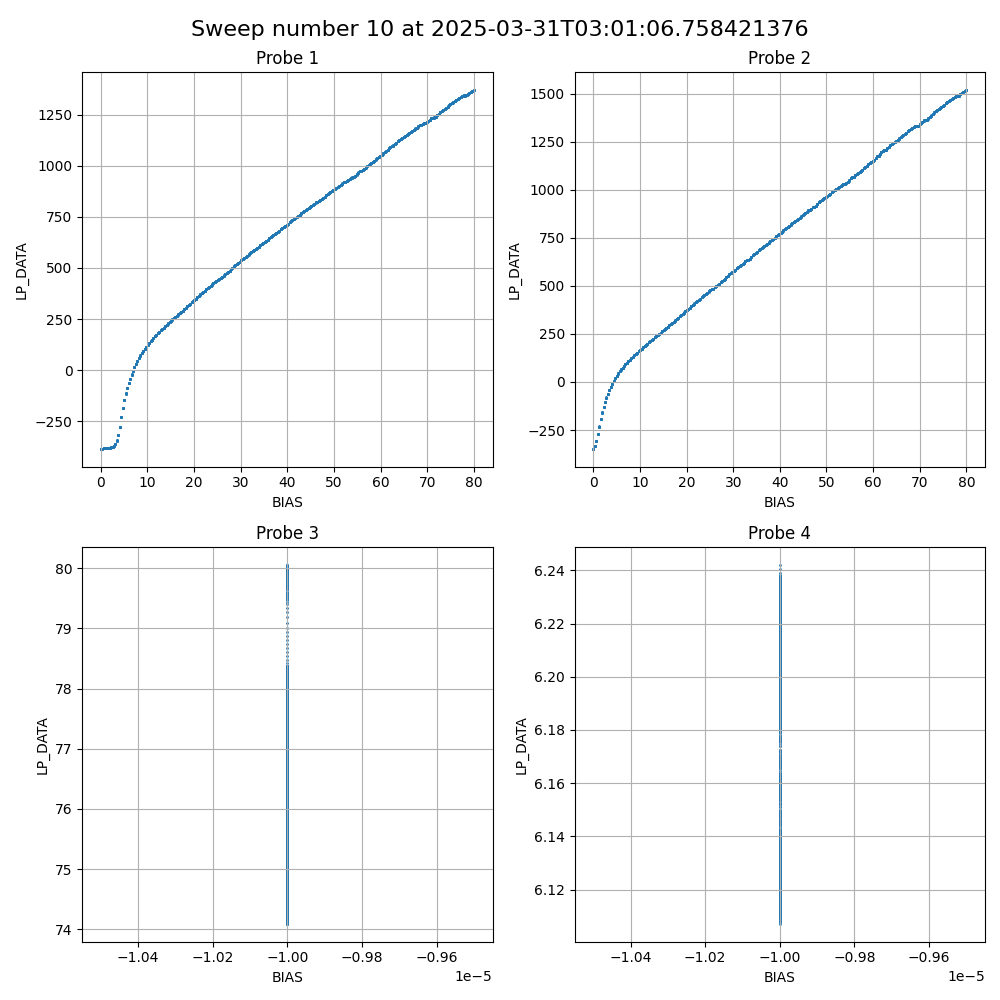

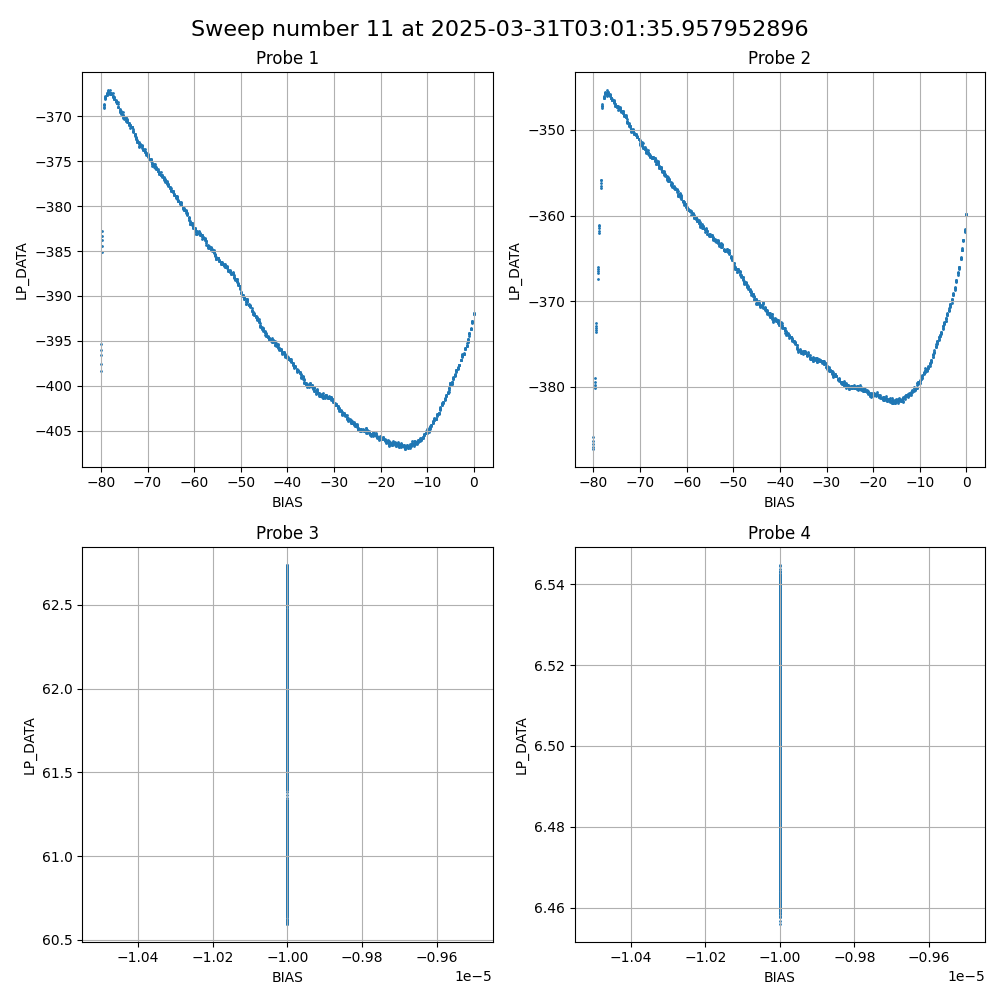

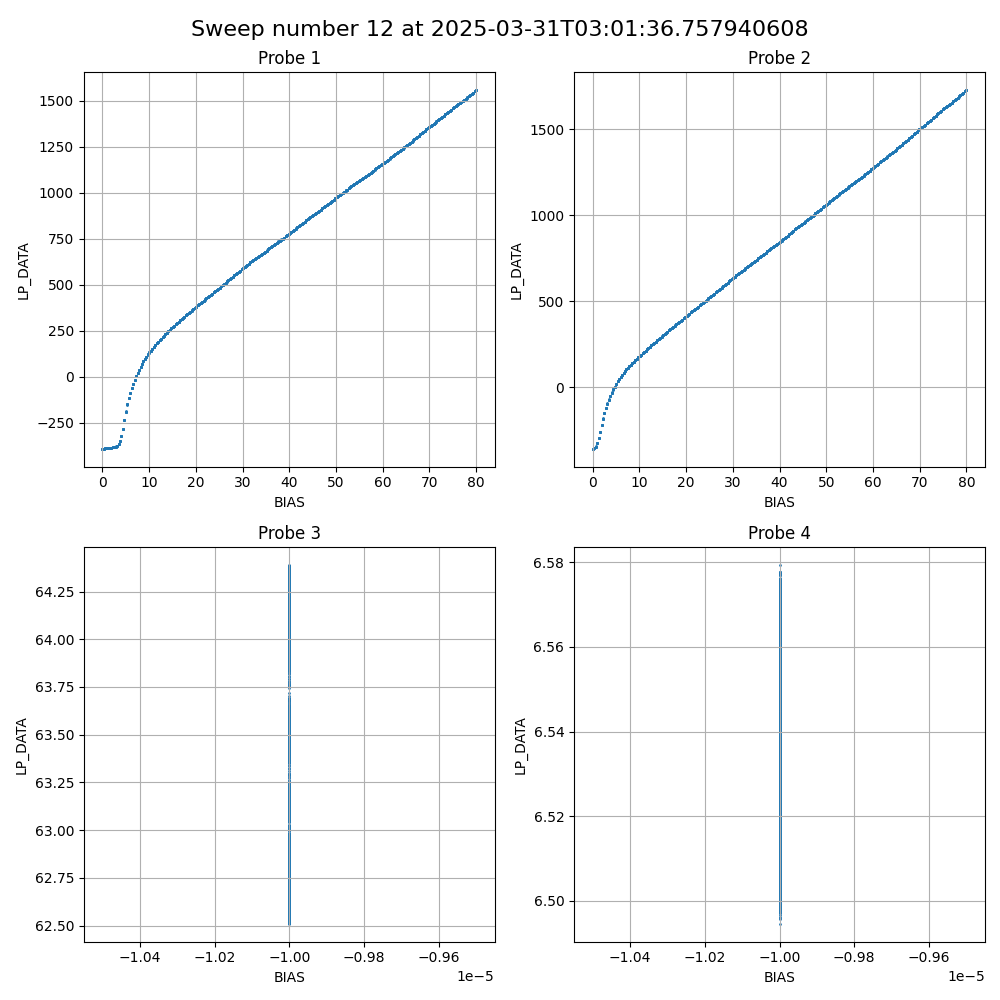

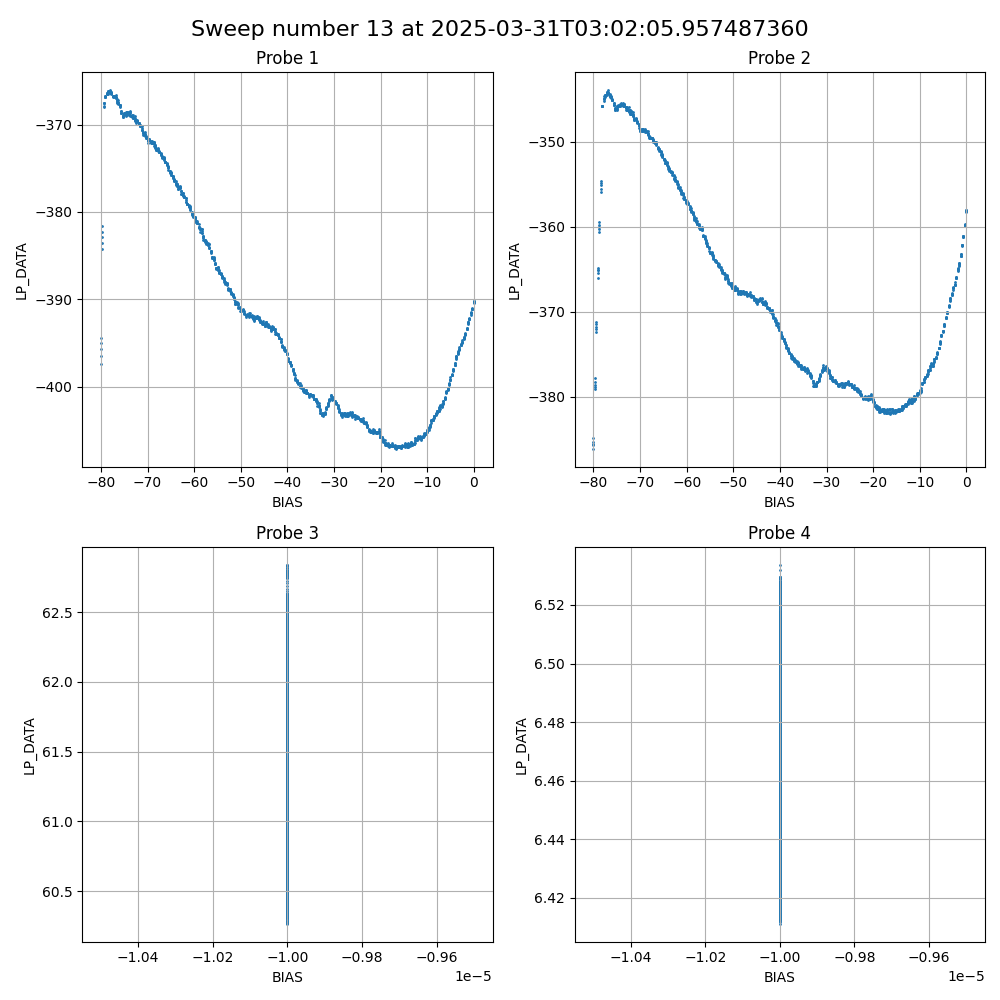

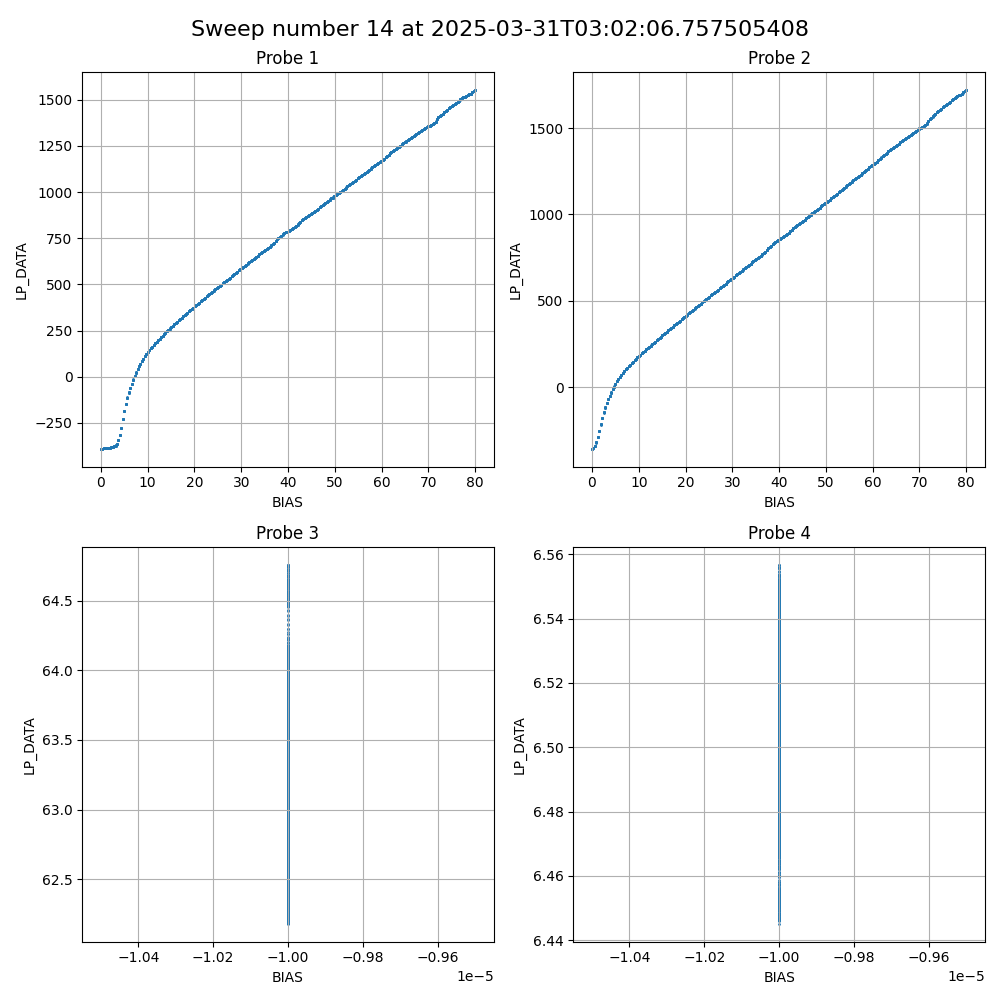

In [3]:
# Sweeps (SID 9)

"""
cdf_file = pycdf.CDF('../DATA/JUICE_L1a_RPWI-LP-SID9_SRVY_SWEEP_DSW_20250331T005038_V01.cdf')

epoch = cdf_file['Epoch'][...]
lp_data = cdf_file['LP_DATA_ENG'][...]
bias_data = cdf_file['BIAS_ENG'][...]
mux = cdf_file['ADC_MUX'][...]
probe_mode = cdf_file['PROBE_MODES'][...]
gain = cdf_file['PROBE_GAINS'][...]
operational_mode = cdf_file['OPERATIONAL_MODES'][...]
resistance = cdf_file['PROBE_RESISTANCES'][...]
source = cdf_file['BIAS_SOURCES'][...]
"""

cdf_file = cdflib.CDF('../DATA/JUICE_L1a_RPWI-LP-SID9_SRVY_SWEEP_DSW_20250331T005038_V01.cdf')

print_info(cdf_file)

epoch = cdf_file.varget('Epoch')
lp_data = cdf_file.varget('LP_DATA_ENG')
bias_data = cdf_file.varget('BIAS_ENG')
mux = cdf_file.varget('ADC_MUX')
probe_mode = cdf_file.varget('PROBE_MODES')
gain = cdf_file.varget('PROBE_GAINS')
operational_mode = cdf_file.varget('OPERATIONAL_MODES')
resistance = cdf_file.varget('PROBE_RESISTANCES')
source = cdf_file.varget('BIAS_SOURCES')
sampling_rate = cdf_file.varget('SAMPLING_RATE_DS')

# Convert epoch from nanoseconds since J2000 to datetime
#epoch = [REF_DATE + dt.timedelta(seconds=t / 1e9) for t in epoch]
epoch = cdflib.cdfepoch.to_datetime(epoch)

"""
# Specify the start date and step size
start_date = epoch[12]
step_size = dt.timedelta(seconds=1 / sampling_rate[0])

# Generate the table of dates
date_table = [start_date + i * step_size for i in range(4864)]
"""

nb_sweeps = len(lp_data)

# Reshaping lp_data to extract  arrays of size 4*5120
filtered_lp_data = [lp_data[i, :, :] for i in range(nb_sweeps)]

# Reshaping bias_data to extract  arrays of size 4*5120
filtered_bias_data = [bias_data[i, :, :] for i in range(nb_sweeps)]

filtered_lp_data = [np.where(np.abs(data) > 1e10, np.nan, data) for data in filtered_lp_data]
filtered_bias_data = [np.where(np.abs(data) > 1e10, np.nan, data) for data in filtered_bias_data]

for i in range(14):
    plt.figure(figsize=(10, 10))
    plt.suptitle(f'Sweep number {i+1} at {epoch[i]}', fontsize=16)
    
    for probe in range(4):
        plt.subplot(2, 2, probe + 1)
        plt.scatter(filtered_bias_data[i][probe, :], filtered_lp_data[i][probe, :], s=1)
        plt.title(f'Probe {probe + 1}')
        plt.xlabel('BIAS')
        plt.ylabel('LP_DATA')
        plt.grid()

    plt.figtext(0.5, -0.15, mux[i] + str(probe_mode[i]) + str(gain[i]) + str(operational_mode[i]) + str(resistance[i]) + str(source[i]), ha='center', va='bottom', fontsize=10, wrap=True)

    plt.tight_layout()
    plt.show()

#pycdf.CDF.close(cdf_file)

Delta distance: 95903252.24847092 km
Delta time: 59.199538424982045 hours
Date2: 2025-03-28 15:48:01.661670

Delta distance: 94845554.32401991 km
Delta time: 58.54663847161723 hours
Date2: 2025-03-28 16:27:12.101502

Delta distance: 94865270.93748245 km
Delta time: 58.558809220668174 hours
Date2: 2025-03-28 16:26:28.286806

Delta distance: 94864903.49481392 km
Delta time: 58.55858240420612 hours
Date2: 2025-03-28 16:26:29.103345

Angular separation: 35.00158717374379 degrees


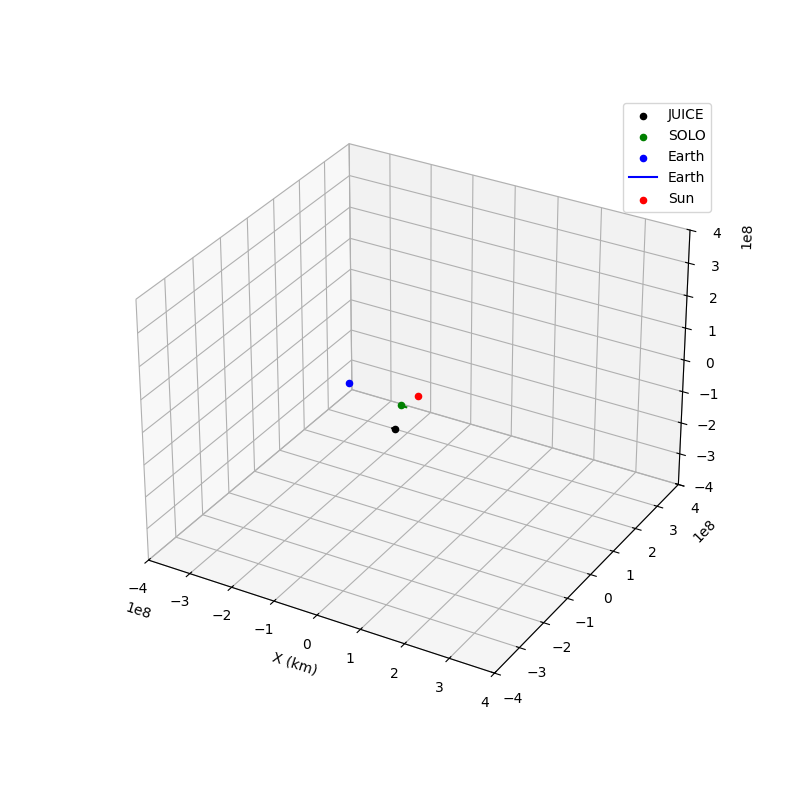

In [19]:
spice.furnsh("../SPICE/Solar_Orbiter/kernels/mk/solo_ANC_soc-flown-mk_v111_20250425_002.tm")
spice.furnsh("../SPICE/JUICE/kernels/mk/juice_ops.tm")

date1 = "2025-03-31T03:00:00"
et1 = spice.str2et(date1)

pos_juice, _ = spice.spkpos("JUICE", et1, "ECLIPJ2000", "NONE", "SUN")
pos_solo, _ = spice.spkpos("SOLAR ORBITER", et1, "ECLIPJ2000", "NONE", "SUN")

distance_juice = np.linalg.norm(pos_juice)
distance_solo = np.linalg.norm(pos_solo)

sw_speed = 450  # km/s
old_delta = 0
delta_dist = distance_juice - distance_solo


while(abs(old_delta - delta_dist) > 1e2):
    delta_time = delta_dist / sw_speed  # in seconds
    print(f"Delta distance: {delta_dist} km")
    print(f"Delta time: {delta_time/(60*60)} hours")
    date2 = dt.datetime.strptime(date1, "%Y-%m-%dT%H:%M:%S") - dt.timedelta(seconds=delta_time)
    print(f"Date2: {date2}")
    et2 = spice.str2et(date2.strftime("%Y-%m-%dT%H:%M:%S"))
    pos_solo, _ = spice.spkpos("SOLAR ORBITER", et2, "ECLIPJ2000", "NONE", "SUN")
    distance_solo = np.linalg.norm(pos_solo)
    old_delta = delta_dist
    delta_dist = distance_juice - distance_solo
    print()

interval = np.linspace(et2, et1, 1000)
pos_earth, _ = spice.spkpos("EARTH", interval, "ECLIPJ2000", "NONE", "SUN")
pos_solo, _ = spice.spkpos("SOLAR ORBITER", interval, "ECLIPJ2000", "NONE", "SUN")
pos_juice, _ = spice.spkpos("JUICE", interval, "ECLIPJ2000", "NONE", "SUN")

# Get the angular separation between JUICE at date1 and SOLO at date2 using a spiceypy function
angular_separation = spice.vsep(pos_juice[-1], pos_solo[0])  # in radians
# Print the angular separation in degrees
print(f"Angular separation: {angular_separation * 180 / np.pi} degrees")

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pos_juice[-1, 0], pos_juice[-1, 1], pos_juice[-1, 2], color='black', label='JUICE')
ax.plot(pos_juice[:, 0], pos_juice[:, 1], pos_juice[:, 2], color='black')
ax.scatter(pos_solo[0, 0], pos_solo[0, 1], pos_solo[0, 2], color='green', label='SOLO')
ax.plot(pos_solo[:, 0], pos_solo[:, 1], pos_solo[:, 2], color='green')
ax.scatter(pos_earth[-1, 0], pos_earth[-1, 1], pos_earth[-1, 2], color='blue', label='Earth')
ax.plot(pos_earth[:, 0], pos_earth[:, 1], pos_earth[:, 2], color='blue', label='Earth')
ax.scatter(0, 0, 0, color='red', label='Sun')
ax.set_xlim(-4e8, 4e8)
ax.set_ylim(-4e8, 4e8)
ax.set_zlim(-4e8, 4e8)
ax.set_xlabel('X (km)')
ax.set_label('Y (km)')
ax.set_label('Z (km)')
ax.legend()
plt.show()

spice.unload("SPICE/Solar_Orbiter/kernels/mk/solo_ANC_soc-flown-mk_v111_20250425_002.tm")
spice.unload("SPICE/JUICE/kernels/mk/juice_ops.tm")

SpiceSPKINSUFFDATA: 
================================================================================

Toolkit version: CSPICE_N0067

SPICE(SPKINSUFFDATA) --

Insufficient ephemeris data has been loaded to compute the position of -28 (JUICE) relative to 699 (SATURN) at the ephemeris epoch 2035 OCT 01 00:01:09.182.

spkpos_c --> SPKPOS --> SPKEZP --> SPKGPS

================================================================================

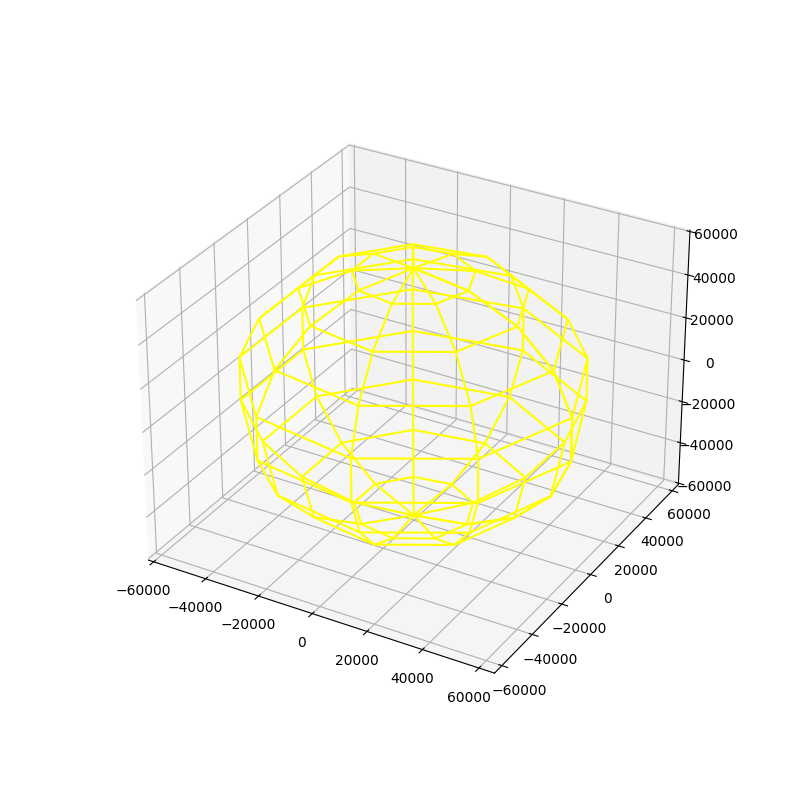

In [14]:
kernels = [
    "../SPICE/JUICE/kernels/mk/juice_plan.tm"]

frame = "ECLIPJ2000"

start_date = "2035-10-01T00:00:00"
end_date = "2035-10-04T22:00:00"

center_body = "SATURN"

bodies = [
    "JUICE",
]

colors = [
    "black",
]

plot_orbits(kernels, frame, start_date, end_date, center_body, bodies, colors, sun_direction=False)